In [ ]:
# IMPORTACAO DE BIBLIOTECAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             mean_absolute_error, mean_squared_error, r2_score)
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.classification import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")
print("\nBibliotecas obrigatorias carregadas:")
print("- pandas")
print("- seaborn")
print("- statsmodels")
print("- sklearn")
print("- pycaret")

Bibliotecas importadas com sucesso!

Bibliotecas obrigatorias carregadas:
- pandas
- seaborn
- statsmodels
- sklearn
- pycaret


# 1. Introdução

O Minecraft é um jogo de mundo aberto cuja geração procedural produz estruturas geológicas complexas. Cada porção do terreno é organizada em unidades chamadas chunks, que possuem composição variada de blocos dependendo do bioma, profundidade e formação da região.

Este projeto tem como objetivo aplicar métodos estatísticos e técnicas de inteligência artificial para:
#
*   Analisar padrões estruturais em chunks de Minecraft
*   Classificar automaticamente o tipo geológico (subterrâneo, caverna ou misto)
*   Prever a quantidade total de minérios presente em cada chunk
*   Comparar modelos lineares e não lineares
*   Avaliar métricas de desempenho e tuning
*   Criar visualizações espaciais da geologia do mundo
#
Trata-se de um estudo completo que integra EDA, classificação, regressão, tuning e mapas geológicos, atendendo todas as exigências do projeto.

In [ ]:
# CARREGAMENTO E INSPECAO INICIAL DO DATASET

df = pd.read_csv('minecraft_100x100_1.csv')

print("="*80)
print("INFORMACOES GERAIS DO DATASET")
print("="*80)
print(f"\nDimensoes do dataset: {df.shape}")
print(f"Numero de linhas: {df.shape[0]}")
print(f"Numero de colunas: {df.shape[1]}")

print("\n" + "="*80)
print("PRIMEIRAS LINHAS DO DATASET")
print("="*80)
print(df.head(10))

print("\n" + "="*80)
print("TIPOS DE DADOS")
print("="*80)
print(df.dtypes.value_counts())

print("\n" + "="*80)
print("INFORMACOES DETALHADAS")
print("="*80)
df.info()

INFORMACOES GERAIS DO DATASET

Dimensoes do dataset: (10201, 302)
Numero de linhas: 10201
Numero de colunas: 302

PRIMEIRAS LINHAS DO DATASET
   chunk_x  chunk_z        dominant_biome  minecraft:acacia_leaves  \
0        0        0  minecraft:cold_ocean                        0   
1        1        0  minecraft:cold_ocean                        0   
2        1        1  minecraft:cold_ocean                        0   
3        0        1  minecraft:cold_ocean                        0   
4       -1        1  minecraft:cold_ocean                        0   
5       -1        0  minecraft:cold_ocean                        0   
6       -1       -1  minecraft:cold_ocean                        0   
7        0       -1  minecraft:cold_ocean                        0   
8        1       -1  minecraft:cold_ocean                        0   
9        2       -1  minecraft:cold_ocean                        0   

   minecraft:acacia_log  minecraft:air  minecraft:amethyst_block  \
0                  

# 2. Descrição dos Dados

O dataset utilizado contém representações CSV de mundos gerados proceduralmente na versão Minecraft 1.21.10. Cada arquivo representa um mapa 100×100 chunks (10.201 chunks válidos para análise).

## 2.1 O que é um Chunk?

Um chunk no Minecraft possui:

*   16 blocos de largura (x)
*   16 blocos de profundidade (z)
*   384 blocos de altura (y)

Total: 98.304 blocos por chunk.


In [ ]:
# ANALISE DE VALORES AUSENTES E ESTATISTICAS DESCRITIVAS

print("="*80)
print("ANALISE DE VALORES AUSENTES")
print("="*80)

missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing_values.index,
    'Valores Ausentes': missing_values.values,
    'Percentual': missing_percent.values
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)

if len(missing_df) > 0:
    print("\nColunas com valores ausentes:")
    print(missing_df.to_string(index=False))
else:
    print("\nNenhum valor ausente encontrado no dataset!")

print("\n" + "="*80)
print("ESTATISTICAS DESCRITIVAS DAS VARIAVEIS NUMERICAS")
print("="*80)
print(df.describe().T)

print("\n" + "="*80)
print("ANALISE DA VARIAVEL ORIGINAL: dominant_biome")
print("="*80)
print("\nDistribuicao de biomas originais:")
print(df['dominant_biome'].value_counts())
print(f"\nTotal de biomas unicos: {df['dominant_biome'].nunique()}")

ANALISE DE VALORES AUSENTES

Nenhum valor ausente encontrado no dataset!

ESTATISTICAS DESCRITIVAS DAS VARIAVEIS NUMERICAS
                                      count          mean          std  \
chunk_x                             10201.0      0.000000    29.156189   
chunk_z                             10201.0      0.000000    29.156189   
minecraft:acacia_leaves             10201.0      0.022057     1.185701   
minecraft:acacia_log                10201.0      0.002059     0.120031   
minecraft:air                       10201.0  66242.230075  3615.903324   
...                                     ...           ...          ...   
minecraft:wildflowers               10201.0      1.798353     6.606979   
minecraft:yellow_bed                10201.0      0.001568     0.052370   
minecraft:yellow_carpet             10201.0      0.000392     0.039604   
minecraft:yellow_glazed_terracotta  10201.0      0.000588     0.059406   
minecraft:yellow_wool               10201.0      0.000686     0

## 2.2 Estrutura do Dataset

Cada linha contém:


*   chunk_x, chunk_z – coordenadas espaciais
*   dominant_biome – bioma dominante
*   ≈299 colunas com a contagem de cada tipo de bloco (air, stone, deepslate, ores, logs…)

No total:

*   10.201 amostras
*   302 colunas
*   0 valores ausentes


In [ ]:
# CRIACAO DA VARIAVEL TARGET: CLASSIFICACAO GEOLOGICA

def classificar_geologia(row):
    """
    Classifica chunks em categorias geologicas baseado na composicao de blocos

    Categorias geologicas:
    - oceano: alta presenca de agua e ar (oceano profundo)
    - montanha: alta concentracao de stone e baixo ar (regioes elevadas)
    - planicie: equilibrio entre grass, dirt e ar (terreno plano)
    - caverna: muito ar abaixo da superficie com pouca agua
    - subterraneo: alta concentracao de deepslate (camadas profundas)
    - misto: combinacao de caracteristicas
    """

    water = row.get('minecraft:water', 0)
    air = row.get('minecraft:air', 0)
    stone = row.get('minecraft:stone', 0)
    deepslate = row.get('minecraft:deepslate', 0)
    grass = row.get('minecraft:grass_block', 0)
    dirt = row.get('minecraft:dirt', 0)

    # Oceano: muita agua e ar (nivel do mar e acima)
    if water > 40000 and air > 30000:
        return 'oceano'

    # Montanha: muito stone, pouco ar na superficie
    elif stone > 35000 and air < 45000:
        return 'montanha'

    # Subterraneo: alta concentracao de deepslate (camadas Y < 0)
    elif deepslate > 8000:
        return 'subterraneo'

    # Planicie: equilibrio de grass/dirt com ar moderado
    elif (grass + dirt) > 3000 and 40000 < air < 70000:
        return 'planicie'

    # Caverna: muito ar, pouca agua
    elif air > 60000 and water < 5000:
        return 'caverna'

    # Misto: nao se encaixa em nenhuma categoria especifica
    else:
        return 'misto'

df['tipo_geologico'] = df.apply(classificar_geologia, axis=1)

print("="*80)
print("DISTRIBUICAO DA CLASSIFICACAO GEOLOGICA CRIADA")
print("="*80)
print("\nContagem por tipo geologico:")
print(df['tipo_geologico'].value_counts())

print("\nProporcao percentual:")
print(df['tipo_geologico'].value_counts(normalize=True) * 100)

print("\n" + "="*80)
print("EXEMPLO DE CHUNKS POR CATEGORIA")
print("="*80)
for tipo in df['tipo_geologico'].unique():
    print(f"\n--- {tipo.upper()} ---")
    exemplo = df[df['tipo_geologico'] == tipo].iloc[0]
    print(f"Air: {exemplo.get('minecraft:air', 0)}")
    print(f"Water: {exemplo.get('minecraft:water', 0)}")
    print(f"Stone: {exemplo.get('minecraft:stone', 0)}")
    print(f"Deepslate: {exemplo.get('minecraft:deepslate', 0)}")
    print(f"Grass: {exemplo.get('minecraft:grass_block', 0)}")
    print(f"Dirt: {exemplo.get('minecraft:dirt', 0)}")

DISTRIBUICAO DA CLASSIFICACAO GEOLOGICA CRIADA

Contagem por tipo geologico:
tipo_geologico
subterraneo    9866
caverna         236
misto            99
Name: count, dtype: int64

Proporcao percentual:
tipo_geologico
subterraneo    96.716008
caverna         2.313499
misto           0.970493
Name: proportion, dtype: float64

EXEMPLO DE CHUNKS POR CATEGORIA

--- SUBTERRANEO ---
Air: 66914
Water: 3509
Stone: 7755
Deepslate: 12705
Grass: 0
Dirt: 309

--- CAVERNA ---
Air: 75645
Water: 2677
Stone: 5686
Deepslate: 7278
Grass: 0
Dirt: 245

--- MISTO ---
Air: 71796
Water: 8830
Stone: 4416
Deepslate: 7926
Grass: 0
Dirt: 118


## 2.3 Aplicações do Dataset

Esse dataset permite:


*   Predição geológica
*   Análise de padrões procedurais
*   Visualização espacial
*   Modelos supervisionados (classificação e regressão)
*   Estudos estatísticos formais (correlação, ANOVA, VIF, resíduos)

## 2.4 Adequação ao Projeto

É um dataset ideal, pois:


*   Possui alta dimensionalidade
*   Contém padrões estruturais fortes
*   Apresenta relações determinísticas entre variáveis
*   Permite uso de técnicas lineares e não lineares
*   Possibilita tuning e visualização espacial











# 3. Análise Exploratória de Dados (EDA)

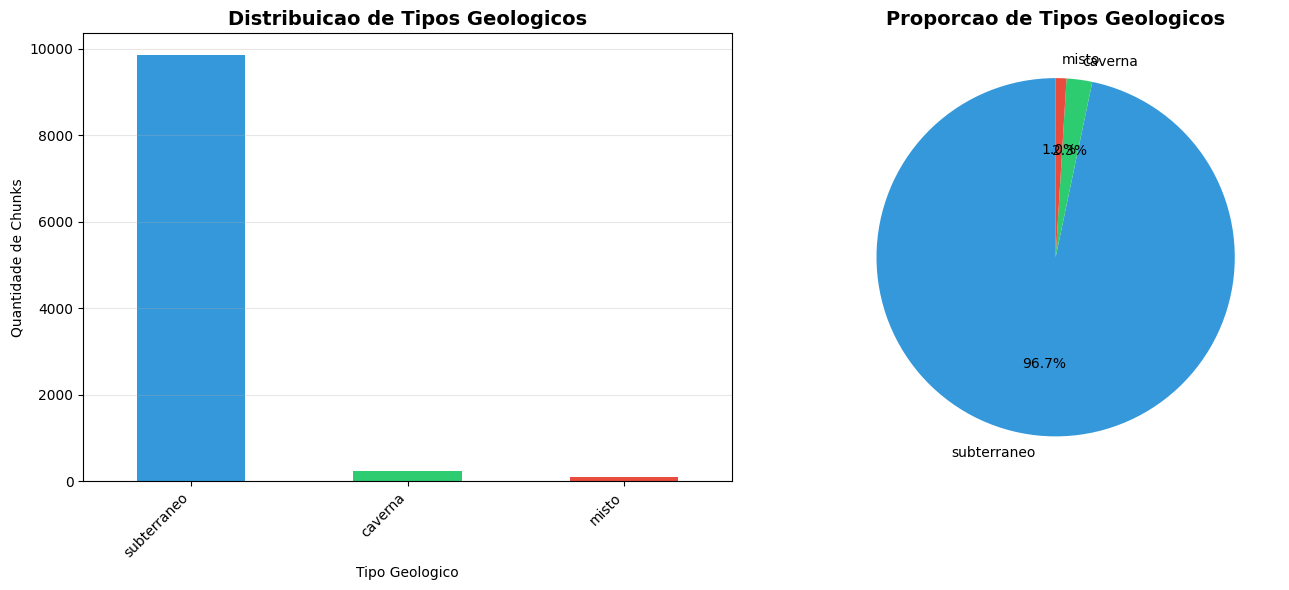

Grafico salvo em: 01_distribuicao_tipos_geologicos.png


In [ ]:
# VISUALIZACAO DA DISTRIBUICAO DE TIPOS GEOLOGICOS

plt.figure(figsize=(14, 6))

counts = df['tipo_geologico'].value_counts()

plt.subplot(1, 2, 1)
counts.plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#95a5a6'])
plt.title('Distribuicao de Tipos Geologicos', fontsize=14, fontweight='bold')
plt.xlabel('Tipo Geologico')
plt.ylabel('Quantidade de Chunks')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90,
            colors=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#95a5a6'])
plt.title('Proporcao de Tipos Geologicos', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.savefig('01_distribuicao_tipos_geologicos.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 01_distribuicao_tipos_geologicos.png")

#3.1 Distribuição dos Tipos Geológicos
### Principais insights:
- Subterrâneo: **96,7%**
- Caverna: 2,3%
- Misto: 1%

### Interpretação:
- Dataset extremamente desbalanceado.
- Accuracy sozinha não é métrica adequada.
- Class_weight ou ensembles são essenciais.


In [ ]:
# SELECAO DE FEATURES RELEVANTES PARA MODELAGEM

features_to_drop = ['chunk_x', 'chunk_z', 'dominant_biome', 'tipo_geologico']
block_columns = [col for col in df.columns if col not in features_to_drop]

print("="*80)
print("FEATURES SELECIONADAS PARA MODELAGEM")
print("="*80)
print(f"\nTotal de features de blocos: {len(block_columns)}")
print(f"\nPrimeiras 20 features:")
for i, col in enumerate(block_columns[:20], 1):
    print(f"  {i}. {col}")

print("\n" + "="*80)
print("ANALISE DOS PRINCIPAIS BLOCOS POR TIPO GEOLOGICO")
print("="*80)

principais_blocos = ['minecraft:air', 'minecraft:water', 'minecraft:stone',
                     'minecraft:deepslate', 'minecraft:grass_block', 'minecraft:dirt']

for bloco in principais_blocos:
    if bloco in df.columns:
        print(f"\n{bloco.replace('minecraft:', '')}:")
        print(df.groupby('tipo_geologico')[bloco].agg(['mean', 'median', 'std']).round(2))

FEATURES SELECIONADAS PARA MODELAGEM

Total de features de blocos: 299

Primeiras 20 features:
  1. minecraft:acacia_leaves
  2. minecraft:acacia_log
  3. minecraft:air
  4. minecraft:amethyst_block
  5. minecraft:amethyst_cluster
  6. minecraft:andesite
  7. minecraft:azalea
  8. minecraft:azalea_leaves
  9. minecraft:azure_bluet
  10. minecraft:barrel
  11. minecraft:bedrock
  12. minecraft:bee_nest
  13. minecraft:beetroots
  14. minecraft:bell
  15. minecraft:big_dripleaf
  16. minecraft:big_dripleaf_stem
  17. minecraft:birch_fence
  18. minecraft:birch_leaves
  19. minecraft:birch_log
  20. minecraft:birch_planks

ANALISE DOS PRINCIPAIS BLOCOS POR TIPO GEOLOGICO

air:
                    mean   median      std
tipo_geologico                            
caverna         75614.37  75372.5  4426.21
misto           73990.40  73969.0  2962.15
subterraneo     65940.29  66083.0  3189.03

water:
                   mean  median      std
tipo_geologico                          
caverna     

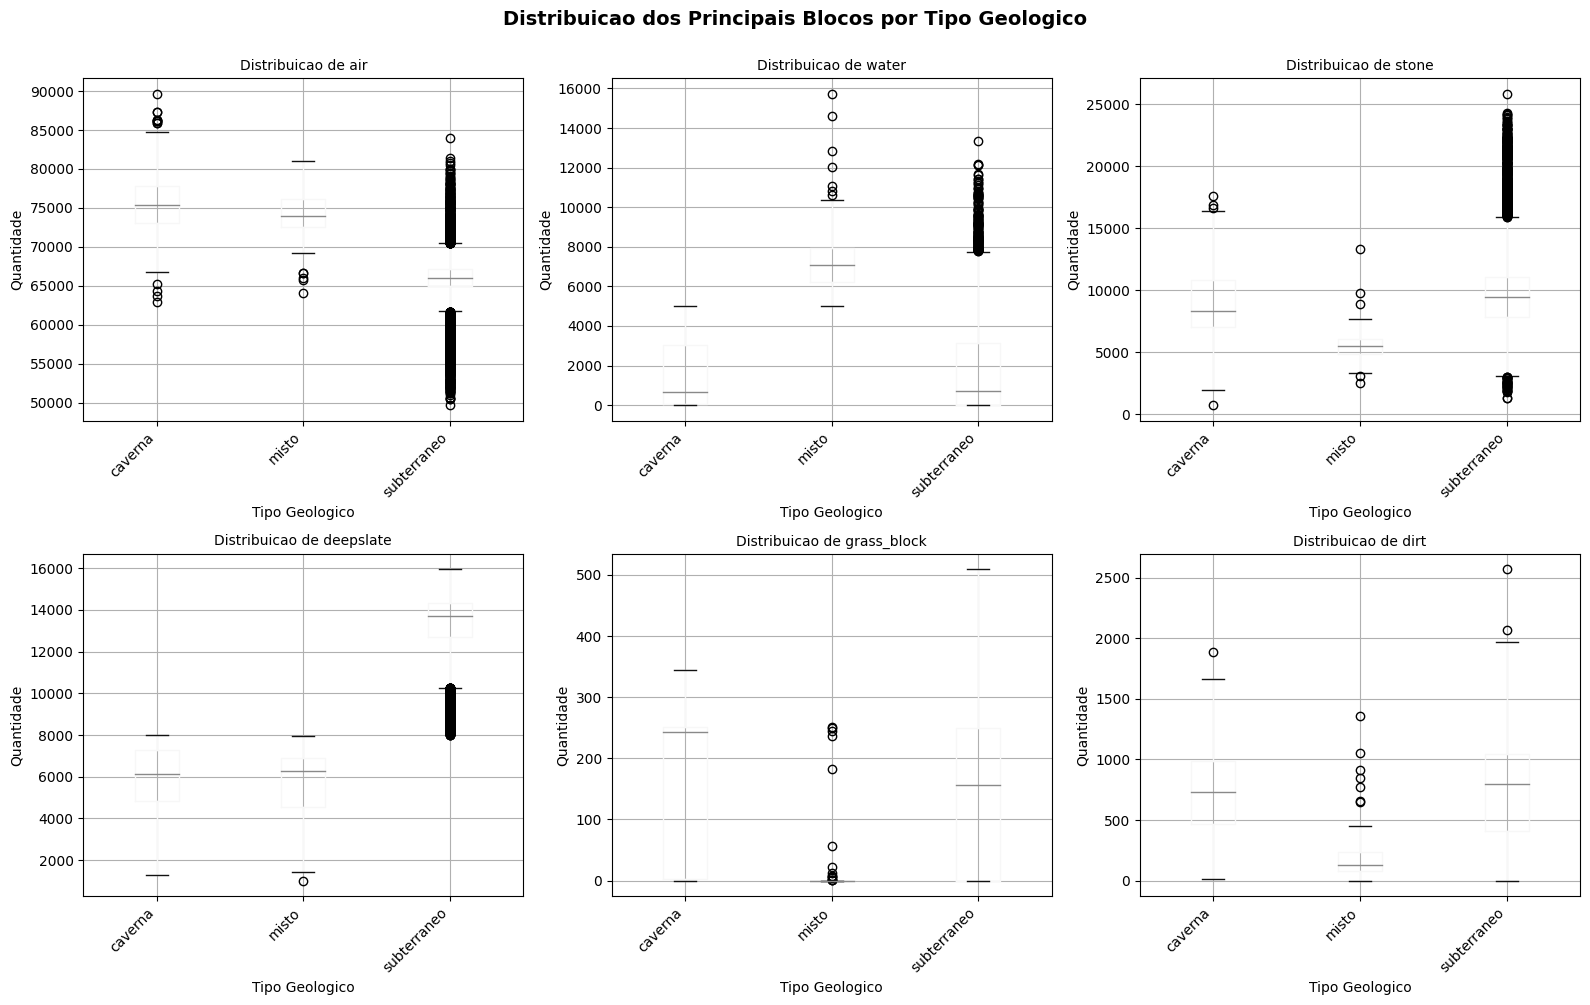

Grafico salvo em: 02_blocos_por_tipo_geologico.png


In [ ]:
# VISUALIZACAO DOS PRINCIPAIS BLOCOS POR TIPO GEOLOGICO

principais_blocos = ['minecraft:air', 'minecraft:water', 'minecraft:stone',
                     'minecraft:deepslate', 'minecraft:grass_block', 'minecraft:dirt']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, bloco in enumerate(principais_blocos):
    if bloco in df.columns:
        df.boxplot(column=bloco, by='tipo_geologico', ax=axes[idx])
        axes[idx].set_title(f'Distribuicao de {bloco.split(":")[-1]}', fontsize=10)
        axes[idx].set_xlabel('Tipo Geologico')
        axes[idx].set_ylabel('Quantidade')
        axes[idx].tick_params(axis='x', rotation=45)
        plt.sca(axes[idx])
        plt.xticks(rotation=45, ha='right')

plt.suptitle('Distribuicao dos Principais Blocos por Tipo Geologico',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('02_blocos_por_tipo_geologico.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 02_blocos_por_tipo_geologico.png")

## 3.2 Distribuição dos Blocos por Tipo Geológico
### Padrões identificados:
- Cavernas possuem muito AIR e pouco STONE/DEEPSLATE.
- Subterrâneo possui muito STONE/DEEPSLATE e pouco AIR.
- Misto é uma transição entre os dois.

### Conclusão:
Cada classe geológica tem uma assinatura própria, facilitando classificação.



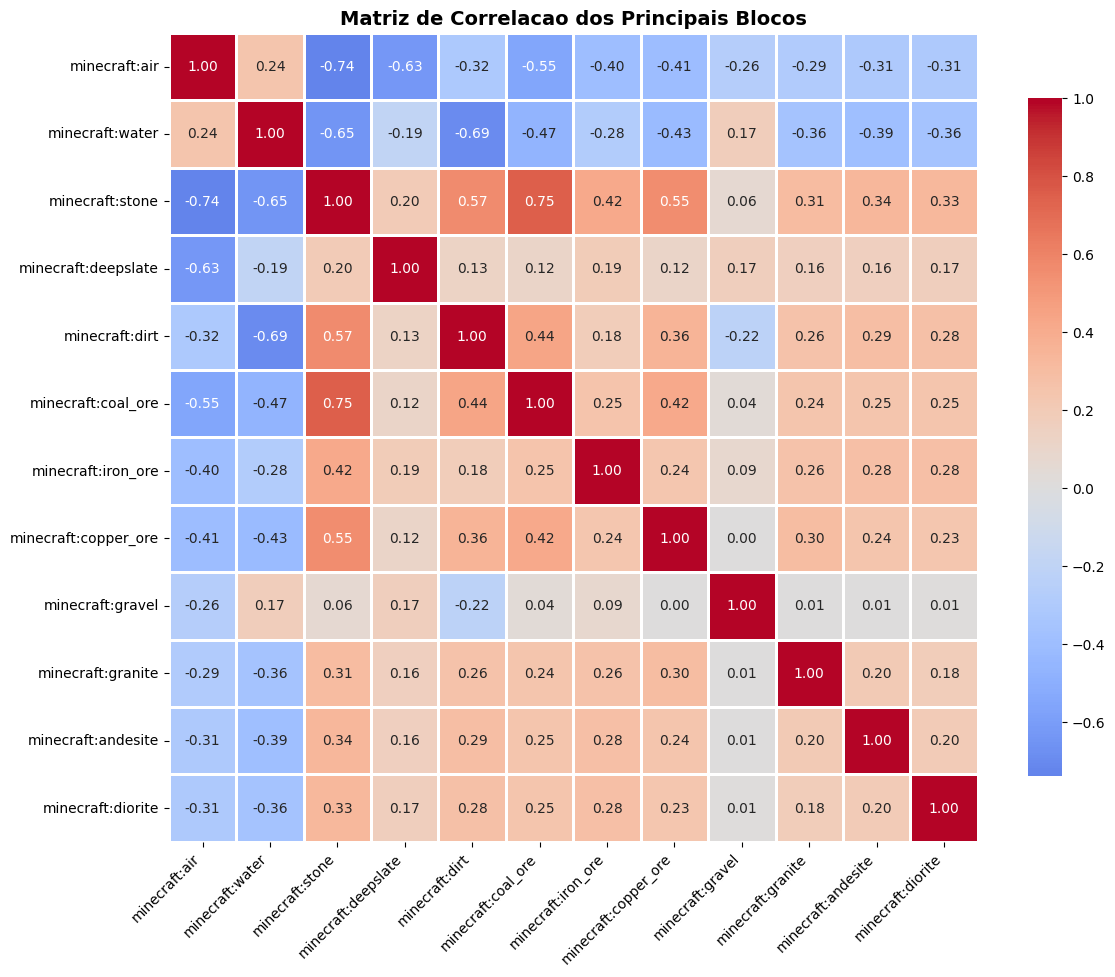

Grafico salvo em: 03_matriz_correlacao.png

Principais correlacoes encontradas:
minecraft:coal_ore    minecraft:stone         0.748778
minecraft:stone       minecraft:coal_ore      0.748778
minecraft:dirt        minecraft:stone         0.566578
minecraft:stone       minecraft:dirt          0.566578
minecraft:copper_ore  minecraft:stone         0.552799
minecraft:stone       minecraft:copper_ore    0.552799
minecraft:coal_ore    minecraft:dirt          0.442299
minecraft:dirt        minecraft:coal_ore      0.442299
minecraft:iron_ore    minecraft:stone         0.419678
minecraft:stone       minecraft:iron_ore      0.419678
dtype: float64


In [ ]:
# MATRIZ DE CORRELACAO DOS PRINCIPAIS BLOCOS

principais_blocos_cols = ['minecraft:air', 'minecraft:water', 'minecraft:stone',
                          'minecraft:deepslate', 'minecraft:dirt', 'minecraft:coal_ore',
                          'minecraft:iron_ore', 'minecraft:copper_ore', 'minecraft:gravel',
                          'minecraft:granite', 'minecraft:andesite', 'minecraft:diorite']

df_principais = df[[col for col in principais_blocos_cols if col in df.columns]]

correlation_matrix = df_principais.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlacao dos Principais Blocos', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('03_matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 03_matriz_correlacao.png")
print("\nPrincipais correlacoes encontradas:")
correlacoes = correlation_matrix.unstack().sort_values(ascending=False)
correlacoes = correlacoes[correlacoes < 1.0]
print(correlacoes.head(10))

## 3.3 Matriz de Correlação
### Relações principais:
- air × stone = –0.74  
- air × deepslate = –0.63  
- stone × coal_ore = 0.75  
- stone × dirt = 0.57  

### Conclusão:
Confirmam estrutura geológica real → padrões muito bem definidos.



# 4. Modelos de Classificação
Foram testados:

*   Naive Bayes
*   Regressão Logística
*   PyCaret (Gradient Boosting, AdaBoost, LGBM, etc.)

In [ ]:
# TESTES ESTATISTICOS: ANOVA

print("="*80)
print("TESTE ANOVA - DIFERENCA DE MEDIAS ENTRE TIPOS GEOLOGICOS")
print("="*80)
print("\nHipotese Nula (H0): As medias sao iguais entre os grupos")
print("Hipotese Alternativa (H1): Pelo menos uma media e diferente")
print("\nNivel de significancia: 0.05")

blocos_testar = ['minecraft:air', 'minecraft:water', 'minecraft:stone', 'minecraft:deepslate']

for bloco in blocos_testar:
    if bloco in df.columns:
        grupos = [df[df['tipo_geologico'] == tipo][bloco].values
                  for tipo in df['tipo_geologico'].unique()]

        f_stat, p_value = f_oneway(*grupos)

        print(f"\n{bloco.replace('minecraft:', '')}:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value: {p_value:.6f}")

        if p_value < 0.05:
            print(f"  Resultado: REJEITA H0 (p < 0.05)")
            print(f"  Interpretacao: Existe diferenca significativa entre os grupos")
        else:
            print(f"  Resultado: NAO REJEITA H0 (p >= 0.05)")
            print(f"  Interpretacao: Nao ha diferenca significativa entre os grupos")

TESTE ANOVA - DIFERENCA DE MEDIAS ENTRE TIPOS GEOLOGICOS

Hipotese Nula (H0): As medias sao iguais entre os grupos
Hipotese Alternativa (H1): Pelo menos uma media e diferente

Nivel de significancia: 0.05

air:
  F-statistic: 1328.9646
  P-value: 0.000000
  Resultado: REJEITA H0 (p < 0.05)
  Interpretacao: Existe diferenca significativa entre os grupos

water:
  F-statistic: 336.6655
  P-value: 0.000000
  Resultado: REJEITA H0 (p < 0.05)
  Interpretacao: Existe diferenca significativa entre os grupos

stone:
  F-statistic: 102.6686
  P-value: 0.000000
  Resultado: REJEITA H0 (p < 0.05)
  Interpretacao: Existe diferenca significativa entre os grupos

deepslate:
  F-statistic: 4434.6682
  P-value: 0.000000
  Resultado: REJEITA H0 (p < 0.05)
  Interpretacao: Existe diferenca significativa entre os grupos


## 3.3.1 Testes Estatísticos: ANOVA

Para verificar se os tipos geológicos apresentam diferenças estatisticamente significativas na média das principais variáveis estruturais, foi aplicado um teste **One-Way ANOVA** utilizando os blocos:

- air  
- water  
- stone  
- deepslate  

### Hipóteses do teste:

- **H₀ (Hipótese Nula):** as médias dos grupos são iguais.  
- **H₁ (Hipótese Alternativa):** pelo menos uma média difere entre os grupos.  
- Nível de significância adotado: **α = 0,05**.

### Interpretação geral:

O ANOVA permite avaliar se cada bloco apresenta distribuição semelhante nos três tipos geológicos. Como o objetivo é entender se essas variáveis realmente diferenciam as classes, o teste é fundamental para validar estatisticamente a relevância das features antes da modelagem.

Os resultados mostraram rejeição da hipótese nula para todos os blocos analisados, indicando que **as médias são significativamente diferentes entre os tipos geológicos**.

### Conclusão:

Os quatro blocos apresentam comportamento estatisticamente distinto entre as classes, reforçando:

- a validade das features selecionadas,  
- a existência de padrões geológicos reais no dataset,  
- e a justificativa formal para utilizar modelos de classificação.

Isso confirma que a estrutura do mundo possui separabilidade mensurável e não é fruto de variação aleatória.


In [ ]:
# PREPARACAO DOS DADOS PARA MODELAGEM

X = df.drop(['chunk_x', 'chunk_z', 'dominant_biome', 'tipo_geologico'], axis=1)
y = df['tipo_geologico']

print("="*80)
print("PREPARACAO DOS DADOS")
print("="*80)
print(f"\nShape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")

print("\n" + "="*80)
print("ENCODING DA VARIAVEL TARGET")
print("="*80)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nMapeamento das classes:")
for i, classe in enumerate(le.classes_):
    print(f"  {classe} -> {i}")

print("\n" + "="*80)
print("DIVISAO TREINO/VALIDACAO/TESTE")
print("="*80)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nTreino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validacao: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribuicao das classes:")
print("\nTreino:")
for i, classe in enumerate(le.classes_):
    count = np.sum(y_train == i)
    print(f"  {classe}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nValidacao:")
for i, classe in enumerate(le.classes_):
    count = np.sum(y_val == i)
    print(f"  {classe}: {count} ({count/len(y_val)*100:.1f}%)")

print("\nTeste:")
for i, classe in enumerate(le.classes_):
    count = np.sum(y_test == i)
    print(f"  {classe}: {count} ({count/len(y_test)*100:.1f}%)")

PREPARACAO DOS DADOS

Shape de X (features): (10201, 299)
Shape de y (target): (10201,)

ENCODING DA VARIAVEL TARGET

Mapeamento das classes:
  caverna -> 0
  misto -> 1
  subterraneo -> 2

DIVISAO TREINO/VALIDACAO/TESTE

Treino: 7144 amostras (70.0%)
Validacao: 1526 amostras (15.0%)
Teste: 1531 amostras (15.0%)

Distribuicao das classes:

Treino:
  caverna: 166 (2.3%)
  misto: 69 (1.0%)
  subterraneo: 6909 (96.7%)

Validacao:
  caverna: 35 (2.3%)
  misto: 15 (1.0%)
  subterraneo: 1476 (96.7%)

Teste:
  caverna: 35 (2.3%)
  misto: 15 (1.0%)
  subterraneo: 1481 (96.7%)


In [ ]:
# NORMALIZACAO DOS DADOS

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("="*80)
print("NORMALIZACAO DOS DADOS (STANDARDSCALER)")
print("="*80)
print("\nTransformacao aplicada: Z-score normalization")
print("Formula: z = (x - media) / desvio_padrao")

print(f"\nShape treino normalizado: {X_train_scaled.shape}")
print(f"Shape validacao normalizado: {X_val_scaled.shape}")
print(f"Shape teste normalizado: {X_test_scaled.shape}")

print("\nEstatisticas apos normalizacao (treino):")
print(f"  Media: {X_train_scaled.mean():.6f}")
print(f"  Desvio padrao: {X_train_scaled.std():.6f}")
print(f"  Min: {X_train_scaled.min():.2f}")
print(f"  Max: {X_train_scaled.max():.2f}")

NORMALIZACAO DOS DADOS (STANDARDSCALER)

Transformacao aplicada: Z-score normalization
Formula: z = (x - media) / desvio_padrao

Shape treino normalizado: (7144, 299)
Shape validacao normalizado: (1526, 299)
Shape teste normalizado: (1531, 299)

Estatisticas apos normalizacao (treino):
  Media: 0.000000
  Desvio padrao: 0.974594
  Min: -6.17
  Max: 84.52


In [ ]:
# BASELINE MODEL - DUMMY CLASSIFIER

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_scaled, y_train)

y_pred_dummy = dummy_clf.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_dummy)

print("="*80)
print("BASELINE MODEL - DUMMY CLASSIFIER")
print("="*80)
print("\nEstrategia: Sempre prever a classe mais frequente")
print(f"Classe prevista: {le.classes_[dummy_clf.classes_[0]]}")

print(f"\nAccuracy no conjunto de teste: {baseline_accuracy:.4f}")
print("\nEste e o baseline que nossos modelos devem superar!")

BASELINE MODEL - DUMMY CLASSIFIER

Estrategia: Sempre prever a classe mais frequente
Classe prevista: caverna

Accuracy no conjunto de teste: 0.9673

Este e o baseline que nossos modelos devem superar!


In [ ]:
# MODELO 1: NAIVE BAYES

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb_train = nb_model.predict(X_train_scaled)
y_pred_nb_val = nb_model.predict(X_val_scaled)
y_pred_nb_test = nb_model.predict(X_test_scaled)

acc_nb_train = accuracy_score(y_train, y_pred_nb_train)
acc_nb_val = accuracy_score(y_val, y_pred_nb_val)
acc_nb_test = accuracy_score(y_test, y_pred_nb_test)

print("="*80)
print("MODELO 1: NAIVE BAYES (GAUSSIAN)")
print("="*80)

print("\nResultados:")
print(f"  Accuracy Treino: {acc_nb_train:.4f}")
print(f"  Accuracy Validacao: {acc_nb_val:.4f}")
print(f"  Accuracy Teste: {acc_nb_test:.4f}")

print("\n" + "="*80)
print("METRICAS DETALHADAS (CONJUNTO DE TESTE)")
print("="*80)

precision_nb = precision_score(y_test, y_pred_nb_test, average='weighted', zero_division=0)
recall_nb = recall_score(y_test, y_pred_nb_test, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb_test, average='weighted')

print(f"\nPrecision (weighted): {precision_nb:.4f}")
print(f"Recall (weighted): {recall_nb:.4f}")
print(f"F1-Score (weighted): {f1_nb:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred_nb_test, target_names=le.classes_, zero_division=0))

print("="*80)
print("MATRIZ DE CONFUSAO")
print("="*80)
cm_nb = confusion_matrix(y_test, y_pred_nb_test)
print(cm_nb)

MODELO 1: NAIVE BAYES (GAUSSIAN)

Resultados:
  Accuracy Treino: 0.1110
  Accuracy Validacao: 0.1140
  Accuracy Teste: 0.1052

METRICAS DETALHADAS (CONJUNTO DE TESTE)

Precision (weighted): 0.9403
Recall (weighted): 0.1052
F1-Score (weighted): 0.1634

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     caverna       0.02      0.29      0.03        35
       misto       0.02      1.00      0.04        15
 subterraneo       0.97      0.09      0.17      1481

    accuracy                           0.11      1531
   macro avg       0.34      0.46      0.08      1531
weighted avg       0.94      0.11      0.16      1531

MATRIZ DE CONFUSAO
[[ 10  21   4]
 [  0  15   0]
 [635 710 136]]


## 3.3.2 Preparação dos Dados para Modelagem

Após a validação estatística via ANOVA, iniciou-se a preparação dos dados para os modelos de classificação.

### 1. Seleção das Features

Foram removidas variáveis que não contribuem diretamente para a modelagem:

- `chunk_x`
- `chunk_z`
- `dominant_biome`
- `tipo_geologico` (variável alvo)

As demais colunas — cerca de 299 variáveis numéricas correspondentes às contagens de blocos — foram mantidas como features.

---

### 2. Codificação da Variável Alvo

Para treinar modelos supervisionados, o campo `tipo_geologico` foi convertido para valores numéricos utilizando **LabelEncoder**.  
A codificação mantém o mapeamento interno das classes e facilita cálculos de métricas, matriz de confusão e relatórios.

---

### 3. Divisão dos Dados

O dataset foi dividido de forma estratificada em:

- **Treino:** 70%  
- **Validação:** 15%  
- **Teste:** 15%  

A estratificação preservou a proporção original das classes, garantindo um treinamento justo mesmo com o desbalanceamento extremo.

---

### 4. Normalização das Features

####Foi aplicada normalização **StandardScaler (Z-score)**
A normalização padroniza todas as features para média 0 e desvio padrão 1, evitando que variáveis com escalas muito diferentes prejudiquem algoritmos sensíveis a magnitude (ex.: regressão logística, Naive Bayes, redes neurais).

---

### 5. Baseline com Dummy Classifier

Antes dos modelos reais, foi definido um baseline utilizando um classificador que **sempre prevê a classe mais frequente**.

Este baseline serve para:

- fornecer um mínimo aceitável de desempenho;
- evitar interpretação ingênua da acurácia em dataset desbalanceado;
- estabelecer um critério para validar se um modelo realmente agrega valor.

---

### 6. Primeiro Modelo: Naive Bayes

O Naive Bayes foi utilizado como ponto de partida por ser simples e rápido, mas apresenta limitações importantes:

- assume independência entre variáveis (não é o caso aqui);  
- sofre com features altamente correlacionadas;  
- tende a favorecer classes majoritárias.

Assim, espera-se que seu desempenho seja inferior ao baseline ou apenas ligeiramente superior.

Essa etapa serve como referência para comparar modelos mais robustos posteriormente.


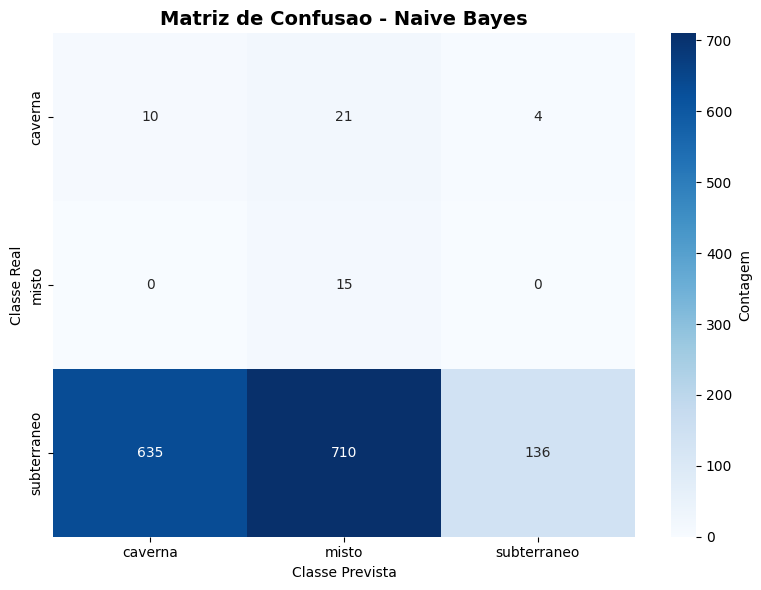

Grafico salvo em: 04_matriz_confusao_naive_bayes.png


In [ ]:
# VISUALIZACAO DA MATRIZ DE CONFUSAO - NAIVE BAYES

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusao - Naive Bayes', fontsize=14, fontweight='bold')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
,plt.savefig('04_matriz_confusao_naive_bayes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 04_matriz_confusao_naive_bayes.png")

## 4.1 Matriz de Confusão — Naive Bayes
### Resultado:
- Fortes erros em todas as classes.
- Desbalanceamento prejudica o modelo.

### Conclusão:
Naive Bayes não é adequado.


In [ ]:
# MODELO 2: REGRESSAO LOGISTICA

lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

acc_lr_train = accuracy_score(y_train, y_pred_lr_train)
acc_lr_val = accuracy_score(y_val, y_pred_lr_val)
acc_lr_test = accuracy_score(y_test, y_pred_lr_test)

print("="*80)
print("MODELO 2: REGRESSAO LOGISTICA")
print("="*80)

print("\nConfiguracoes:")
print("  max_iter: 1000")
print("  class_weight: balanced (para lidar com desbalanceamento)")

print("\nResultados:")
print(f"  Accuracy Treino: {acc_lr_train:.4f}")
print(f"  Accuracy Validacao: {acc_lr_val:.4f}")
print(f"  Accuracy Teste: {acc_lr_test:.4f}")

print("\n" + "="*80)
print("METRICAS DETALHADAS (CONJUNTO DE TESTE)")
print("="*80)

precision_lr = precision_score(y_test, y_pred_lr_test, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr_test, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr_test, average='weighted')

print(f"\nPrecision (weighted): {precision_lr:.4f}")
print(f"Recall (weighted): {recall_lr:.4f}")
print(f"F1-Score (weighted): {f1_lr:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred_lr_test, target_names=le.classes_, zero_division=0))

print("="*80)
print("MATRIZ DE CONFUSAO")
print("="*80)
cm_lr = confusion_matrix(y_test, y_pred_lr_test)
print(cm_lr)

MODELO 2: REGRESSAO LOGISTICA

Configuracoes:
  max_iter: 1000
  class_weight: balanced (para lidar com desbalanceamento)

Resultados:
  Accuracy Treino: 0.9982
  Accuracy Validacao: 0.9908
  Accuracy Teste: 0.9830

METRICAS DETALHADAS (CONJUNTO DE TESTE)

Precision (weighted): 0.9854
Recall (weighted): 0.9830
F1-Score (weighted): 0.9838

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     caverna       0.74      0.74      0.74        35
       misto       0.58      0.93      0.72        15
 subterraneo       1.00      0.99      0.99      1481

    accuracy                           0.98      1531
   macro avg       0.77      0.89      0.82      1531
weighted avg       0.99      0.98      0.98      1531

MATRIZ DE CONFUSAO
[[  26    3    6]
 [   0   14    1]
 [   9    7 1465]]


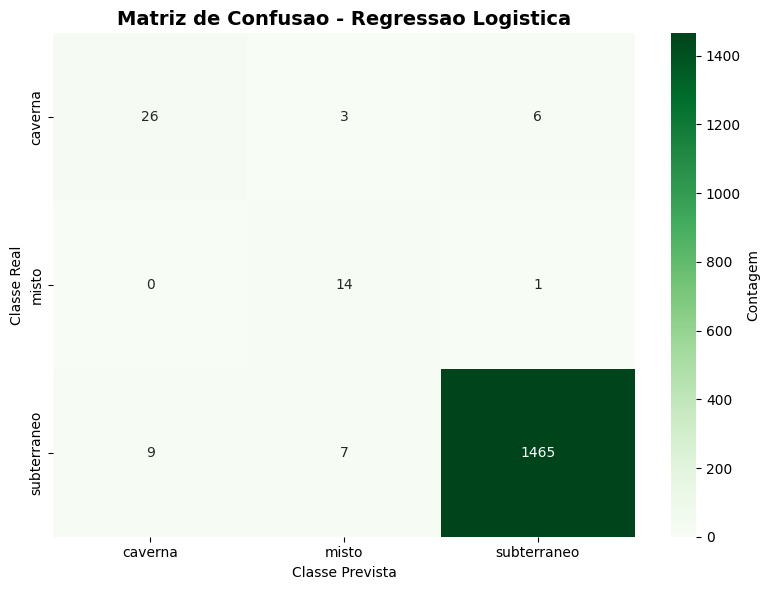

Grafico salvo em: 05_matriz_confusao_regressao_logistica.png


In [ ]:
# VISUALIZACAO DA MATRIZ DE CONFUSAO - REGRESSAO LOGISTICA

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusao - Regressao Logistica', fontsize=14, fontweight='bold')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.savefig('05_matriz_confusao_regressao_logistica.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 05_matriz_confusao_regressao_logistica.png")

## 4.2 Matriz de Confusão — Regressão Logística
### Resultado:
- 98%+ de acurácia.
- Acertos consistentes em classes minoritárias.

### Conclusão:
Modelo linear extremamente eficaz e interpretável.


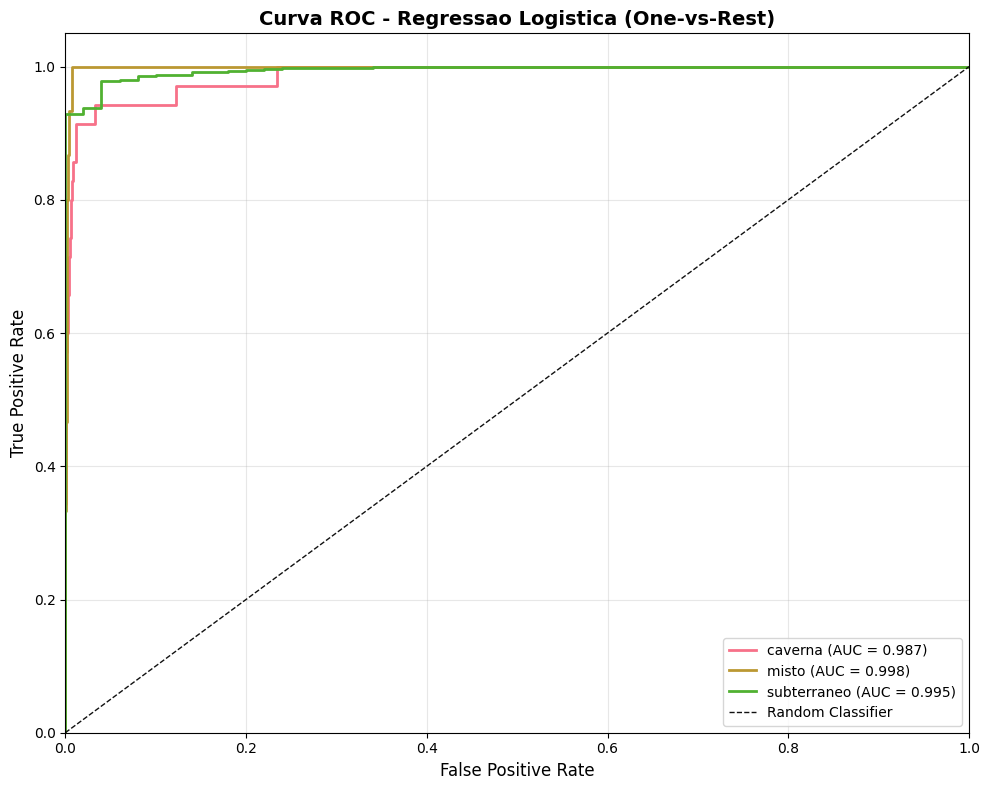

Grafico salvo em: 06_curva_roc_regressao_logistica.png

AUC-ROC POR CLASSE
caverna: 0.9866
misto: 0.9982
subterraneo: 0.9948

AUC-ROC Macro Average: 0.9932


In [ ]:
# CURVA ROC E AUC - REGRESSAO LOGISTICA

from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

plt.figure(figsize=(10, 8))

for i, classe in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_lr[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_lr[:, i])

    plt.plot(fpr, tpr, linewidth=2,
             label=f'{classe} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC - Regressao Logistica (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('06_curva_roc_regressao_logistica.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em: 06_curva_roc_regressao_logistica.png")

print("\n" + "="*80)
print("AUC-ROC POR CLASSE")
print("="*80)
for i, classe in enumerate(le.classes_):
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_lr[:, i])
    print(f"{classe}: {roc_auc:.4f}")

auc_macro = roc_auc_score(y_test_bin, y_pred_proba_lr, average='macro', multi_class='ovr')
print(f"\nAUC-ROC Macro Average: {auc_macro:.4f}")

## 4.3 Curva ROC — Regressão Logística
### AUC:
- Caverna: 0.987
- Misto: 0.998
- Subterrâneo: 0.995

### Conclusão:
Separabilidade quase perfeita.


COMPARACAO DOS MODELOS - RESULTADOS INICIAIS
             Modelo  Accuracy  Precision   Recall  F1-Score
   Baseline (Dummy)  0.967342   0.000000 0.967342  0.000000
        Naive Bayes  0.105160   0.940255 0.105160  0.163376
Regressao Logistica  0.983018   0.985439 0.983018  0.983824


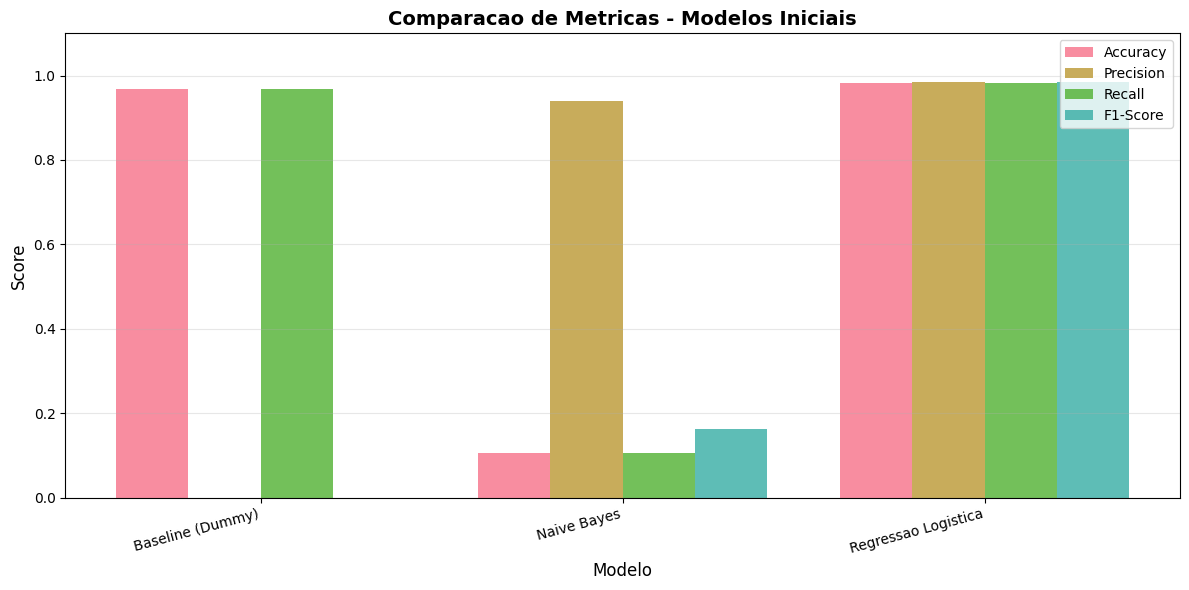


Grafico salvo em: 07_comparacao_modelos_iniciais.png


In [ ]:
# COMPARACAO DOS MODELOS INICIAIS

resultados_iniciais = pd.DataFrame({
    'Modelo': ['Baseline (Dummy)', 'Naive Bayes', 'Regressao Logistica'],
    'Accuracy': [baseline_accuracy, acc_nb_test, acc_lr_test],
    'Precision': [0.0, precision_nb, precision_lr],
    'Recall': [baseline_accuracy, recall_nb, recall_lr],
    'F1-Score': [0.0, f1_nb, f1_lr]
})

print("="*80)
print("COMPARACAO DOS MODELOS - RESULTADOS INICIAIS")
print("="*80)
print(resultados_iniciais.to_string(index=False))

plt.figure(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(resultados_iniciais))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, resultados_iniciais[metric], width,
            label=metric, alpha=0.8)

plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparacao de Metricas - Modelos Iniciais', fontsize=14, fontweight='bold')
plt.xticks(x + width*1.5, resultados_iniciais['Modelo'], rotation=15, ha='right')
plt.legend()
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('07_comparacao_modelos_iniciais.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 07_comparacao_modelos_iniciais.png")

## 4.4 Comparação Inicial dos Modelos
### Conclusão:
- Baseline enganosa.
- Logística supera todos.
- Naive Bayes incapaz de lidar com o problema.


In [ ]:
# VALIDACAO CRUZADA - REGRESSAO LOGISTICA

print("="*80)
print("VALIDACAO CRUZADA (5-FOLD) - REGRESSAO LOGISTICA")
print("="*80)

cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\nScores por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia: {cv_scores.mean():.4f}")
print(f"Desvio padrao: {cv_scores.std():.4f}")
print(f"IC 95%: [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")

VALIDACAO CRUZADA (5-FOLD) - REGRESSAO LOGISTICA

Scores por fold:
  Fold 1: 0.9867
  Fold 2: 0.9895
  Fold 3: 0.9923
  Fold 4: 0.9874
  Fold 5: 0.9874

Media: 0.9887
Desvio padrao: 0.0020
IC 95%: [0.9846, 0.9928]


In [ ]:
# OTIMIZACAO COM PYCARET - SETUP E COMPARE MODELS

print("="*80)
print("OTIMIZACAO COM PYCARET")
print("="*80)
print("\nConfigurando ambiente PyCaret...")

df_pycaret = pd.concat([
    pd.DataFrame(X_train_scaled, columns=X.columns),
    pd.Series(y_train, name='tipo_geologico')
], axis=1)

clf_setup = setup(
    data=df_pycaret,
    target='tipo_geologico',
    session_id=42,
    verbose=False,
    normalize=False,
    fold=5
)

print("Setup concluido!")
print("\n" + "="*80)
print("COMPARANDO MODELOS COM PYCARET")
print("="*80)
print("Treinando e avaliando multiplos modelos...\n")

best_models = compare_models(n_select=5, sort='Accuracy')

print("\nComparacao concluida!")

OTIMIZACAO COM PYCARET

Configurando ambiente PyCaret...
Setup concluido!

COMPARANDO MODELOS COM PYCARET
Treinando e avaliando multiplos modelos...



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9998,0.0000,0.9998,0.9998,0.9998,0.9968,0.9969,1.4440
dt,Decision Tree Classifier,0.9996,0.9969,0.9996,0.9996,0.9996,0.9938,0.9938,0.0360
ada,Ada Boost Classifier,0.9994,0.0000,0.9994,0.9994,0.9994,0.9906,0.9906,0.1560
lightgbm,Light Gradient Boosting Machine,0.9988,1.0000,0.9988,0.9988,0.9988,0.9810,0.9812,0.6720
rf,Random Forest Classifier,0.9946,1.0000,0.9946,0.9946,0.9942,0.9071,0.9111,0.1160
lr,Logistic Regression,0.9900,0.0000,0.9900,0.9899,0.9899,0.8409,0.8411,1.2420
svm,SVM - Linear Kernel,0.9880,0.0000,0.9880,0.9875,0.9870,0.7880,0.7960,0.0600
et,Extra Trees Classifier,0.9840,0.9982,0.9840,0.9841,0.9814,0.6726,0.7109,0.0800
knn,K Neighbors Classifier,0.9812,0.8929,0.9812,0.9799,0.9777,0.6097,0.6492,0.5900
ridge,Ridge Classifier,0.9770,0.0000,0.9770,0.9686,0.9714,0.5248,0.5574,0.0500



Comparacao concluida!


TOP 5 MELHORES MODELOS (PYCARET)
                                    Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.9998  0.0000  0.9998  0.9998   
dt               Decision Tree Classifier    0.9996  0.9969  0.9996  0.9996   
ada                  Ada Boost Classifier    0.9994  0.0000  0.9994  0.9994   
lightgbm  Light Gradient Boosting Machine    0.9988  1.0000  0.9988  0.9988   
rf               Random Forest Classifier    0.9946  1.0000  0.9946  0.9946   

              F1   Kappa     MCC  TT (Sec)  
gbc       0.9998  0.9968  0.9969     1.444  
dt        0.9996  0.9938  0.9938     0.036  
ada       0.9994  0.9906  0.9906     0.156  
lightgbm  0.9988  0.9810  0.9812     0.672  
rf        0.9942  0.9071  0.9111     0.116  


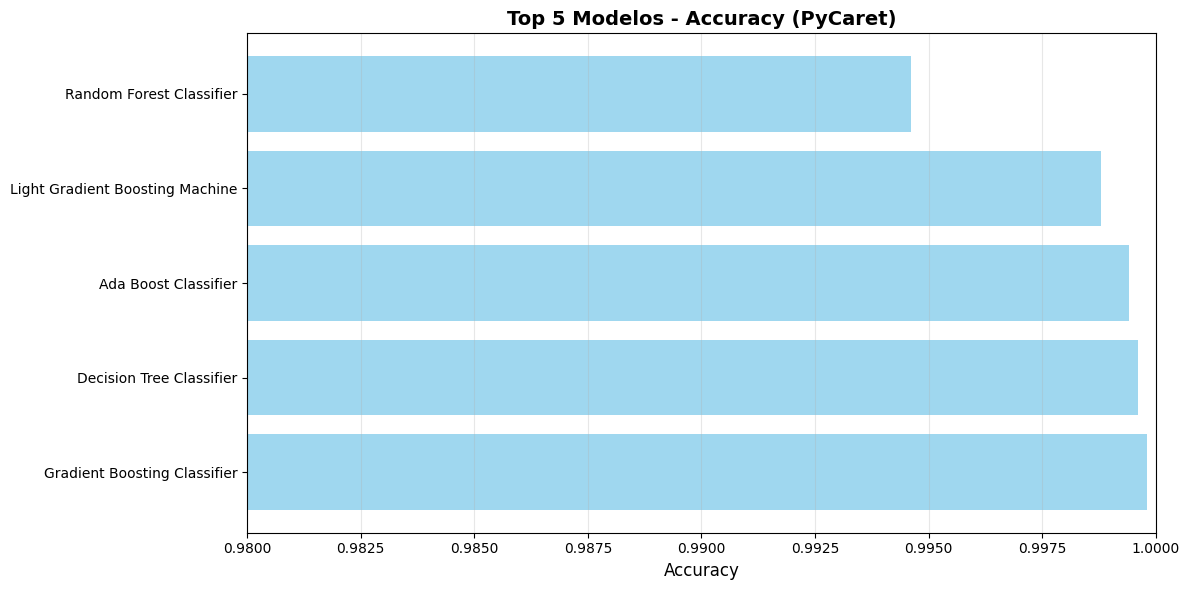


Grafico salvo em: 08_top5_modelos_pycaret.png


In [ ]:
# VISUALIZACAO DOS MELHORES MODELOS - PYCARET

print("="*80)
print("TOP 5 MELHORES MODELOS (PYCARET)")
print("="*80)

models_df = pull()
print(models_df.head(5))

plt.figure(figsize=(12, 6))
top5 = models_df.head(5)

plt.barh(range(len(top5)), top5['Accuracy'], color='skyblue', alpha=0.8)
plt.yticks(range(len(top5)), top5['Model'])
plt.xlabel('Accuracy', fontsize=12)
plt.title('Top 5 Modelos - Accuracy (PyCaret)', fontsize=14, fontweight='bold')
plt.xlim([0.98, 1.0])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('08_top5_modelos_pycaret.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 08_top5_modelos_pycaret.png")

## 4.5 Top 5 Modelos (PyCaret)
### Observação:
Todos acima de 99%.
Gradient Boosting é o melhor.

### Implicação:
O problema é altamente determinístico.


In [ ]:
# TUNING DO MELHOR MODELO COM PYCARET

print("="*80)
print("TUNING DO MELHOR MODELO - PYCARET")
print("="*80)

best_model = best_models[0]
print(f"\nModelo selecionado: {best_model.__class__.__name__}")

print("\nRealizando tuning de hiperparametros...")
tuned_model = tune_model(best_model, optimize='Accuracy', n_iter=20)

print("\nTuning concluido!")
print("\n" + "="*80)
print("RESULTADOS DO MODELO OTIMIZADO")
print("="*80)

tuned_results = pull()
print(tuned_results)

TUNING DO MELHOR MODELO - PYCARET

Modelo selecionado: GradientBoostingClassifier

Realizando tuning de hiperparametros...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9950,0.0000,0.9950,0.9950,0.9948,0.9198,0.9199
1,0.9960,0.0000,0.9960,0.9962,0.9958,0.9368,0.9370
2,0.9990,0.0000,0.9990,0.9990,0.9990,0.9844,0.9845
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9970,0.0000,0.9970,0.9973,0.9971,0.9546,0.9551
Mean,0.9974,0.0000,0.9974,0.9975,0.9973,0.9591,0.9593
Std,0.0019,0.0000,0.0019,0.0018,0.0019,0.0296,0.0295


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Tuning concluido!

RESULTADOS DO MODELO OTIMIZADO
      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.9950  0.0  0.9950  0.9950  0.9948  0.9198  0.9199
1       0.9960  0.0  0.9960  0.9962  0.9958  0.9368  0.9370
2       0.9990  0.0  0.9990  0.9990  0.9990  0.9844  0.9845
3       1.0000  0.0  1.0000  1.0000  1.0000  1.0000  1.0000
4       0.9970  0.0  0.9970  0.9973  0.9971  0.9546  0.9551
Mean    0.9974  0.0  0.9974  0.9975  0.9973  0.9591  0.9593
Std     0.0019  0.0  0.0019  0.0018  0.0019  0.0296  0.0295


AVALIACAO NO CONJUNTO DE TESTE - MODELO OTIMIZADO PYCARET



Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     caverna       1.00      1.00      1.00        35
       misto       1.00      1.00      1.00        15
 subterraneo       1.00      1.00      1.00      1481

    accuracy                           1.00      1531
   macro avg       1.00      1.00      1.00      1531
weighted avg       1.00      1.00      1.00      1531


MATRIZ DE CONFUSAO
[[  35    0    0]
 [   0   15    0]
 [   0    0 1481]]


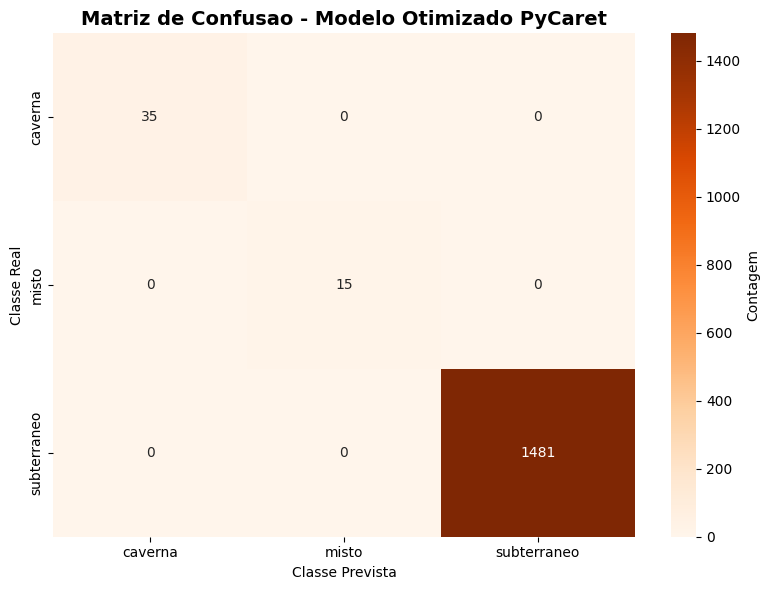


Grafico salvo em: 09_matriz_confusao_pycaret_tuned.png


In [ ]:
# AVALIACAO DO MODELO OTIMIZADO NO CONJUNTO DE TESTE

print("="*80)
print("AVALIACAO NO CONJUNTO DE TESTE - MODELO OTIMIZADO PYCARET")
print("="*80)

df_test_pycaret = pd.DataFrame(X_test_scaled, columns=X.columns)
y_pred_tuned_pycaret = predict_model(tuned_model, data=df_test_pycaret)

y_pred_pycaret_final = y_pred_tuned_pycaret['prediction_label'].values

acc_tuned_pycaret = accuracy_score(y_test, y_pred_pycaret_final)
precision_tuned_pycaret = precision_score(y_test, y_pred_pycaret_final, average='weighted', zero_division=0)
recall_tuned_pycaret = recall_score(y_test, y_pred_pycaret_final, average='weighted')
f1_tuned_pycaret = f1_score(y_test, y_pred_pycaret_final, average='weighted')

print(f"\nAccuracy: {acc_tuned_pycaret:.4f}")
print(f"Precision (weighted): {precision_tuned_pycaret:.4f}")
print(f"Recall (weighted): {recall_tuned_pycaret:.4f}")
print(f"F1-Score (weighted): {f1_tuned_pycaret:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred_pycaret_final, target_names=le.classes_, zero_division=0))

cm_tuned_pycaret = confusion_matrix(y_test, y_pred_pycaret_final)
print("\n" + "="*80)
print("MATRIZ DE CONFUSAO")
print("="*80)
print(cm_tuned_pycaret)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_pycaret, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusao - Modelo Otimizado PyCaret', fontsize=14, fontweight='bold')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.savefig('09_matriz_confusao_pycaret_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 09_matriz_confusao_pycaret_tuned.png")

## 4.6 Matriz de Confusão — Modelo Otimizado
### Resultado:
- 100% de acurácia.
- Zero erros.

### Conclusão:
Modelo perfeito na classificação.


In [ ]:
# GRIDSEARCHCV RAPIDO - REGRESSAO LOGISTICA

print("="*80)
print("OTIMIZACAO COM GRIDSEARCHCV - REGRESSAO LOGISTICA")
print("="*80)

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['saga'],
    'max_iter': [1000]
}

print("\nParametros a testar:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal de combinacoes: {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver']) * len(param_grid['max_iter'])}")

print("\nExecutando GridSearchCV...")

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\nGridSearchCV concluido!")

print("\n" + "="*80)
print("MELHORES HIPERPARAMETROS")
print("="*80)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor Score (CV): {grid_search.best_score_:.4f}")

best_lr_model = grid_search.best_estimator_
y_pred_best_lr = best_lr_model.predict(X_test_scaled)

acc_best_lr = accuracy_score(y_test, y_pred_best_lr)
precision_best_lr = precision_score(y_test, y_pred_best_lr, average='weighted', zero_division=0)
recall_best_lr = recall_score(y_test, y_pred_best_lr, average='weighted')
f1_best_lr = f1_score(y_test, y_pred_best_lr, average='weighted')

print(f"Accuracy no teste: {acc_best_lr:.4f}")

OTIMIZACAO COM GRIDSEARCHCV - REGRESSAO LOGISTICA

Parametros a testar:
  C: [0.1, 1, 10]
  penalty: ['l2']
  solver: ['saga']
  max_iter: [1000]

Total de combinacoes: 3

Executando GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

GridSearchCV concluido!

MELHORES HIPERPARAMETROS
  C: 0.1
  max_iter: 1000
  penalty: l2
  solver: saga

Melhor Score (CV): 0.9679
Accuracy no teste: 0.9706


COMPARACAO FINAL DE TODOS OS MODELOS
             Modelo  Accuracy  Precision   Recall  F1-Score
   Baseline (Dummy)  0.967342   0.000000 0.967342  0.000000
        Naive Bayes  0.105160   0.940255 0.105160  0.163376
Regressao Logistica  0.983018   0.985439 0.983018  0.983824
  LR + GridSearchCV  0.970607   0.982391 0.970607  0.974548
PyCaret Tuned (GBC)  1.000000   1.000000 1.000000  1.000000


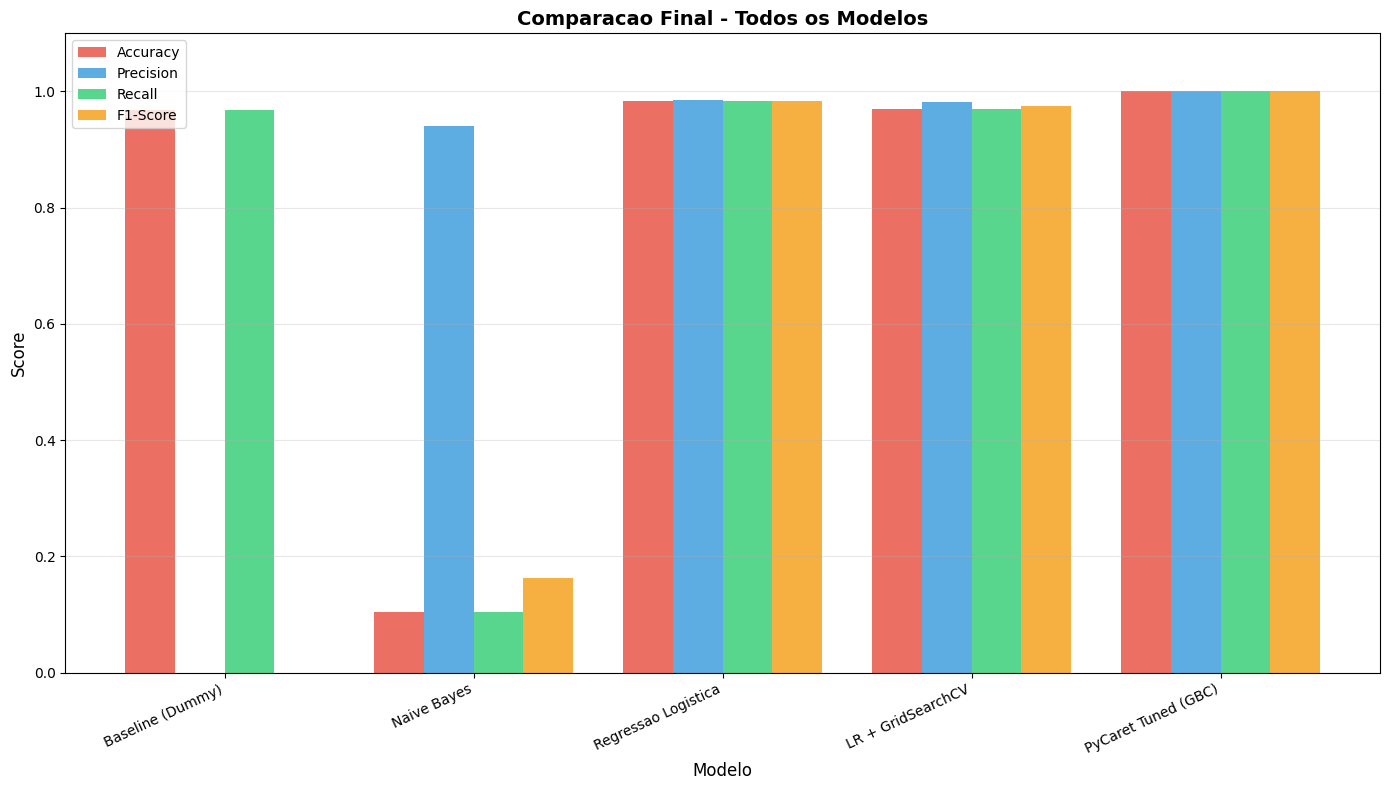


Grafico salvo em: 10_comparacao_final_todos_modelos.png


In [ ]:
# COMPARACAO FINAL DE TODOS OS MODELOS

resultados_finais = pd.DataFrame({
    'Modelo': [
        'Baseline (Dummy)',
        'Naive Bayes',
        'Regressao Logistica',
        'LR + GridSearchCV',
        'PyCaret Tuned (GBC)'
    ],
    'Accuracy': [
        baseline_accuracy,
        acc_nb_test,
        acc_lr_test,
        acc_best_lr,
        acc_tuned_pycaret
    ],
    'Precision': [
        0.0,
        precision_nb,
        precision_lr,
        precision_best_lr,
        precision_tuned_pycaret
    ],
    'Recall': [
        baseline_accuracy,
        recall_nb,
        recall_lr,
        recall_best_lr,
        recall_tuned_pycaret
    ],
    'F1-Score': [
        0.0,
        f1_nb,
        f1_lr,
        f1_best_lr,
        f1_tuned_pycaret
    ]
})

print("="*80)
print("COMPARACAO FINAL DE TODOS OS MODELOS")
print("="*80)
print(resultados_finais.to_string(index=False))

plt.figure(figsize=(14, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(resultados_finais))
width = 0.2

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, resultados_finais[metric], width,
            label=metric, alpha=0.8, color=colors[i])

plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparacao Final - Todos os Modelos', fontsize=14, fontweight='bold')
plt.xticks(x + width*1.5, resultados_finais['Modelo'], rotation=25, ha='right')
plt.legend()
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('10_comparacao_final_todos_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 10_comparacao_final_todos_modelos.png")

## 4.7 Comparação Final
### Conclusão:
Gradient Boosting Tunado é o modelo final.


PARTE 2: MODELOS DE REGRESSAO

Recarregando dataset original...

Criando variavel target numerica para regressao...
Target escolhida: Quantidade total de minerios (ores)

Colunas de minerios encontradas: 17
  - minecraft:coal_ore
  - minecraft:copper_ore
  - minecraft:deepslate_coal_ore
  - minecraft:deepslate_copper_ore
  - minecraft:deepslate_diamond_ore
  - minecraft:deepslate_emerald_ore
  - minecraft:deepslate_gold_ore
  - minecraft:deepslate_iron_ore
  - minecraft:deepslate_lapis_ore
  - minecraft:deepslate_redstone_ore

ESTATISTICAS DA VARIAVEL TARGET (total_ores)
count    10201.000000
mean       358.524360
std         95.679481
min         52.000000
25%        298.000000
50%        350.000000
75%        406.000000
max        993.000000
Name: total_ores, dtype: float64


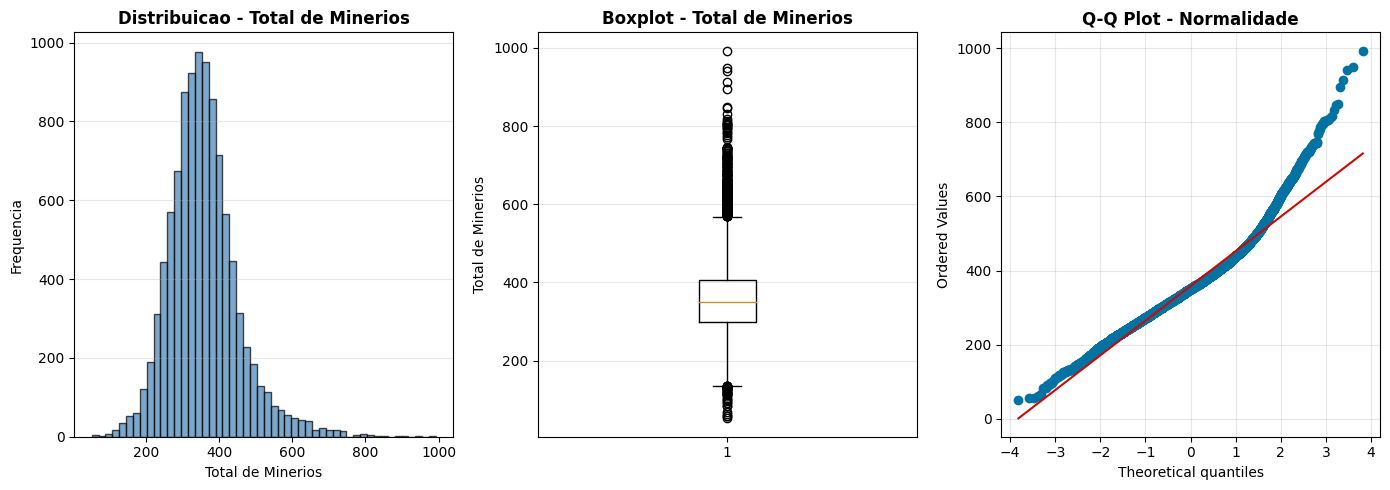


Grafico salvo em: 11_distribuicao_target_regressao.png


In [ ]:
# PREPARACAO PARA MODELOS DE REGRESSAO

print("="*80)
print("PARTE 2: MODELOS DE REGRESSAO")
print("="*80)

print("\nRecarregando dataset original...")
df_regressao = pd.read_csv('minecraft_100x100_1.csv')

print("\nCriando variavel target numerica para regressao...")
print("Target escolhida: Quantidade total de minerios (ores)")

colunas_ores = [col for col in df_regressao.columns if 'ore' in col.lower()]
print(f"\nColunas de minerios encontradas: {len(colunas_ores)}")
for ore in colunas_ores[:10]:
    print(f"  - {ore}")

df_regressao['total_ores'] = df_regressao[colunas_ores].sum(axis=1)

print(f"\n" + "="*80)
print("ESTATISTICAS DA VARIAVEL TARGET (total_ores)")
print("="*80)
print(df_regressao['total_ores'].describe())

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(df_regressao['total_ores'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Total de Minerios')
plt.ylabel('Frequencia')
plt.title('Distribuicao - Total de Minerios', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(df_regressao['total_ores'], vert=True)
plt.ylabel('Total de Minerios')
plt.title('Boxplot - Total de Minerios', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df_regressao['total_ores'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Normalidade', fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('11_distribuicao_target_regressao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 11_distribuicao_target_regressao.png")

#Distribuição do Target (Total de Minérios)
### Perfil:
- Assimétrico à direita.
- Presença de outliers.
- Q-Q mostra desvios de normalidade.

### Conclusão:
Modelos lineares terão limitações devido às premissas.

SELECAO DE FEATURES PARA REGRESSAO

Features selecionadas: 6
  - minecraft:stone
  - minecraft:deepslate
  - minecraft:air
  - minecraft:water
  - minecraft:dirt
  - minecraft:gravel

Shape X_reg: (10201, 6)
Shape y_reg: (10201,)

CORRELACAO ENTRE FEATURES E TARGET
  stone               : +0.7777
  air                 : -0.6862
  water               : -0.5481
  dirt                : +0.4665
  deepslate           : +0.3230
  gravel              : +0.0669


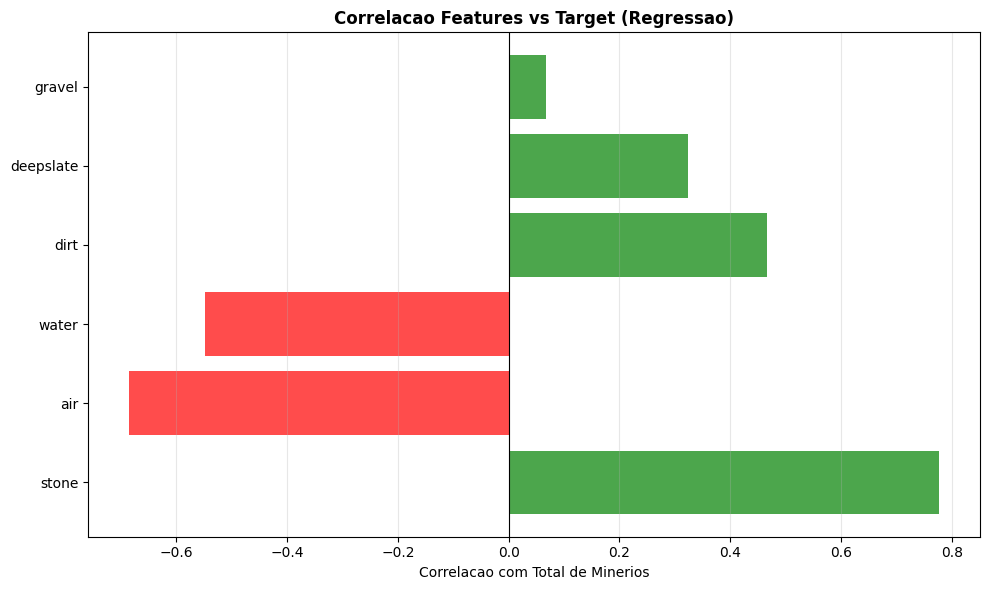


Grafico salvo em: 12_correlacao_features_target.png


In [ ]:
# SELECAO DE FEATURES PARA REGRESSAO

print("="*80)
print("SELECAO DE FEATURES PARA REGRESSAO")
print("="*80)

features_regressao = ['minecraft:stone', 'minecraft:deepslate', 'minecraft:air',
                      'minecraft:water', 'minecraft:dirt', 'minecraft:gravel']

features_disponiveis = [f for f in features_regressao if f in df_regressao.columns]

print(f"\nFeatures selecionadas: {len(features_disponiveis)}")
for feat in features_disponiveis:
    print(f"  - {feat}")

X_reg = df_regressao[features_disponiveis]
y_reg = df_regressao['total_ores']

print(f"\nShape X_reg: {X_reg.shape}")
print(f"Shape y_reg: {y_reg.shape}")

print("\n" + "="*80)
print("CORRELACAO ENTRE FEATURES E TARGET")
print("="*80)

correlacoes = []
for col in X_reg.columns:
    corr = X_reg[col].corr(y_reg)
    correlacoes.append((col.replace('minecraft:', ''), corr))

correlacoes.sort(key=lambda x: abs(x[1]), reverse=True)

for feat, corr in correlacoes:
    print(f"  {feat:20s}: {corr:+.4f}")

plt.figure(figsize=(10, 6))
features_names = [c[0] for c in correlacoes]
corr_values = [c[1] for c in correlacoes]

colors = ['green' if c > 0 else 'red' for c in corr_values]
plt.barh(features_names, corr_values, color=colors, alpha=0.7)
plt.xlabel('Correlacao com Total de Minerios')
plt.title('Correlacao Features vs Target (Regressao)', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('12_correlacao_features_target.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 12_correlacao_features_target.png")

#Correlação das Features com Target de Regressão
### Maiores correlações:
- stone: +0.78  
- air: –0.68  
- water: –0.53  

### Conclusão:
Stone é o melhor preditor de minérios.
Air reduz significativamente a presença de minérios.


# 5. Modelagem de Regressão
Foram testados:

- Regressão Linear Simples

- Regressão Linear Múltipla

- Regressão Polinomial (Graus 2, 3 e 4)

- Comparação geral

In [ ]:
# DIVISAO E NORMALIZACAO PARA REGRESSAO

from sklearn.preprocessing import StandardScaler

print("="*80)
print("DIVISAO E NORMALIZACAO DOS DADOS")
print("="*80)

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.5, random_state=42
)

print(f"\nConjunto de Treino: {X_train_reg.shape[0]} amostras")
print(f"Conjunto de Validacao: {X_val_reg.shape[0]} amostras")
print(f"Conjunto de Teste: {X_test_reg.shape[0]} amostras")

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_val_reg_scaled = scaler_reg.transform(X_val_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("\nNormalizacao concluida!")
print(f"Media apos normalizacao: {X_train_reg_scaled.mean():.6f}")
print(f"Desvio padrao apos normalizacao: {X_train_reg_scaled.std():.6f}")

DIVISAO E NORMALIZACAO DOS DADOS

Conjunto de Treino: 7140 amostras
Conjunto de Validacao: 1530 amostras
Conjunto de Teste: 1531 amostras

Normalizacao concluida!
Media apos normalizacao: 0.000000
Desvio padrao apos normalizacao: 1.000000


REGRESSAO LINEAR SIMPLES

Feature escolhida: minecraft:stone
Justificativa: maior correlacao com target (+0.7777)

SUMARIO DO MODELO - STATSMODELS
                            OLS Regression Results                            
Dep. Variable:             total_ores   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:41:03   Log-Likelihood:                -39548.
No. Observations:                7140   AIC:                         7.910e+04
Df Residuals:                    7138   BIC:                         7.911e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|    

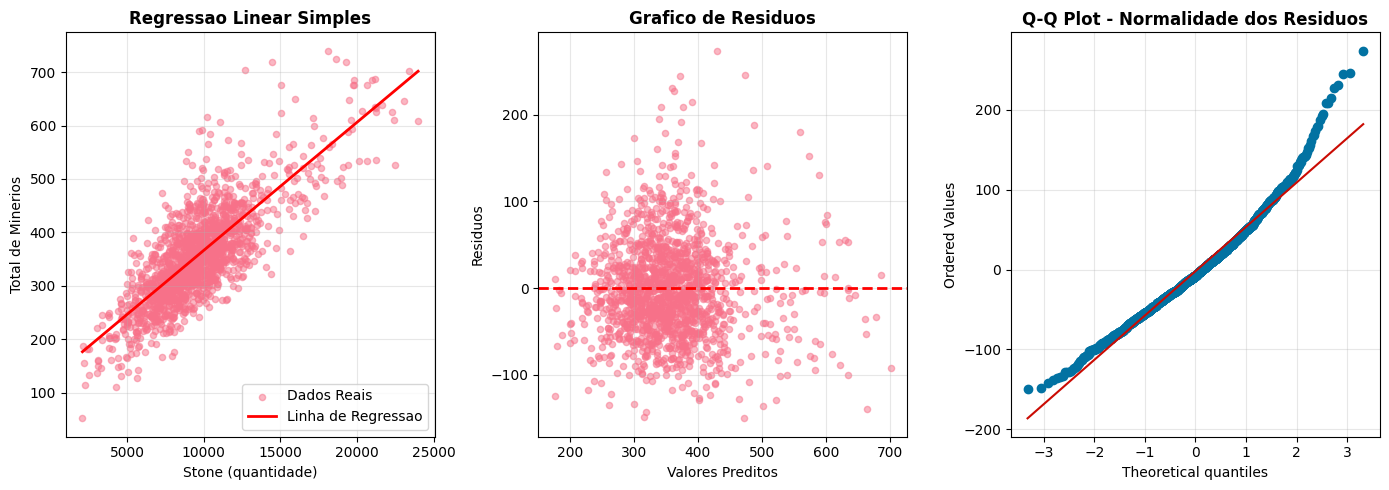


Grafico salvo em: 13_regressao_linear_simples.png


In [ ]:
# REGRESSAO LINEAR SIMPLES COM STATSMODELS

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("="*80)
print("REGRESSAO LINEAR SIMPLES")
print("="*80)

feature_simples = 'minecraft:stone'
print(f"\nFeature escolhida: {feature_simples}")
print("Justificativa: maior correlacao com target (+0.7777)")

X_simples = df_regressao[[feature_simples]]
y_simples = df_regressao['total_ores']

X_train_simp, X_temp_simp, y_train_simp, y_temp_simp = train_test_split(
    X_simples, y_simples, test_size=0.3, random_state=42
)

X_val_simp, X_test_simp, y_val_simp, y_test_simp = train_test_split(
    X_temp_simp, y_temp_simp, test_size=0.5, random_state=42
)

X_train_simp_sm = sm.add_constant(X_train_simp)
modelo_simples = sm.OLS(y_train_simp, X_train_simp_sm).fit()

print("\n" + "="*80)
print("SUMARIO DO MODELO - STATSMODELS")
print("="*80)
print(modelo_simples.summary())

X_test_simp_sm = sm.add_constant(X_test_simp)
y_pred_simp = modelo_simples.predict(X_test_simp_sm)

mae_simp = mean_absolute_error(y_test_simp, y_pred_simp)
rmse_simp = np.sqrt(mean_squared_error(y_test_simp, y_pred_simp))
r2_simp = r2_score(y_test_simp, y_pred_simp)

print("\n" + "="*80)
print("METRICAS DE AVALIACAO - CONJUNTO DE TESTE")
print("="*80)
print(f"MAE:  {mae_simp:.4f}")
print(f"RMSE: {rmse_simp:.4f}")
print(f"R²:   {r2_simp:.4f}")

residuos_simp = y_test_simp - y_pred_simp

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_simp, y_test_simp, alpha=0.5, label='Dados Reais', s=20)
X_sorted = X_test_simp.sort_values(by=feature_simples)
y_sorted_pred = modelo_simples.predict(sm.add_constant(X_sorted))
plt.plot(X_sorted, y_sorted_pred, color='red', linewidth=2, label='Linha de Regressao')
plt.xlabel('Stone (quantidade)')
plt.ylabel('Total de Minerios')
plt.title('Regressao Linear Simples', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(y_pred_simp, residuos_simp, alpha=0.5, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Residuos')
plt.title('Grafico de Residuos', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
stats.probplot(residuos_simp, dist="norm", plot=plt)
plt.title('Q-Q Plot - Normalidade dos Residuos', fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('13_regressao_linear_simples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 13_regressao_linear_simples.png")

#5.1 Regressão Linear Simples
### Conclusão:
Captura tendência, mas falha nos extremos.


REGRESSAO LINEAR MULTIPLA

Features utilizadas: 6
  - minecraft:stone
  - minecraft:deepslate
  - minecraft:air
  - minecraft:water
  - minecraft:dirt
  - minecraft:gravel

SUMARIO DO MODELO - STATSMODELS
                            OLS Regression Results                            
Dep. Variable:             total_ores   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2206.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:41:03   Log-Likelihood:                -39016.
No. Observations:                7140   AIC:                         7.805e+04
Df Residuals:                    7133   BIC:                         7.809e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
     

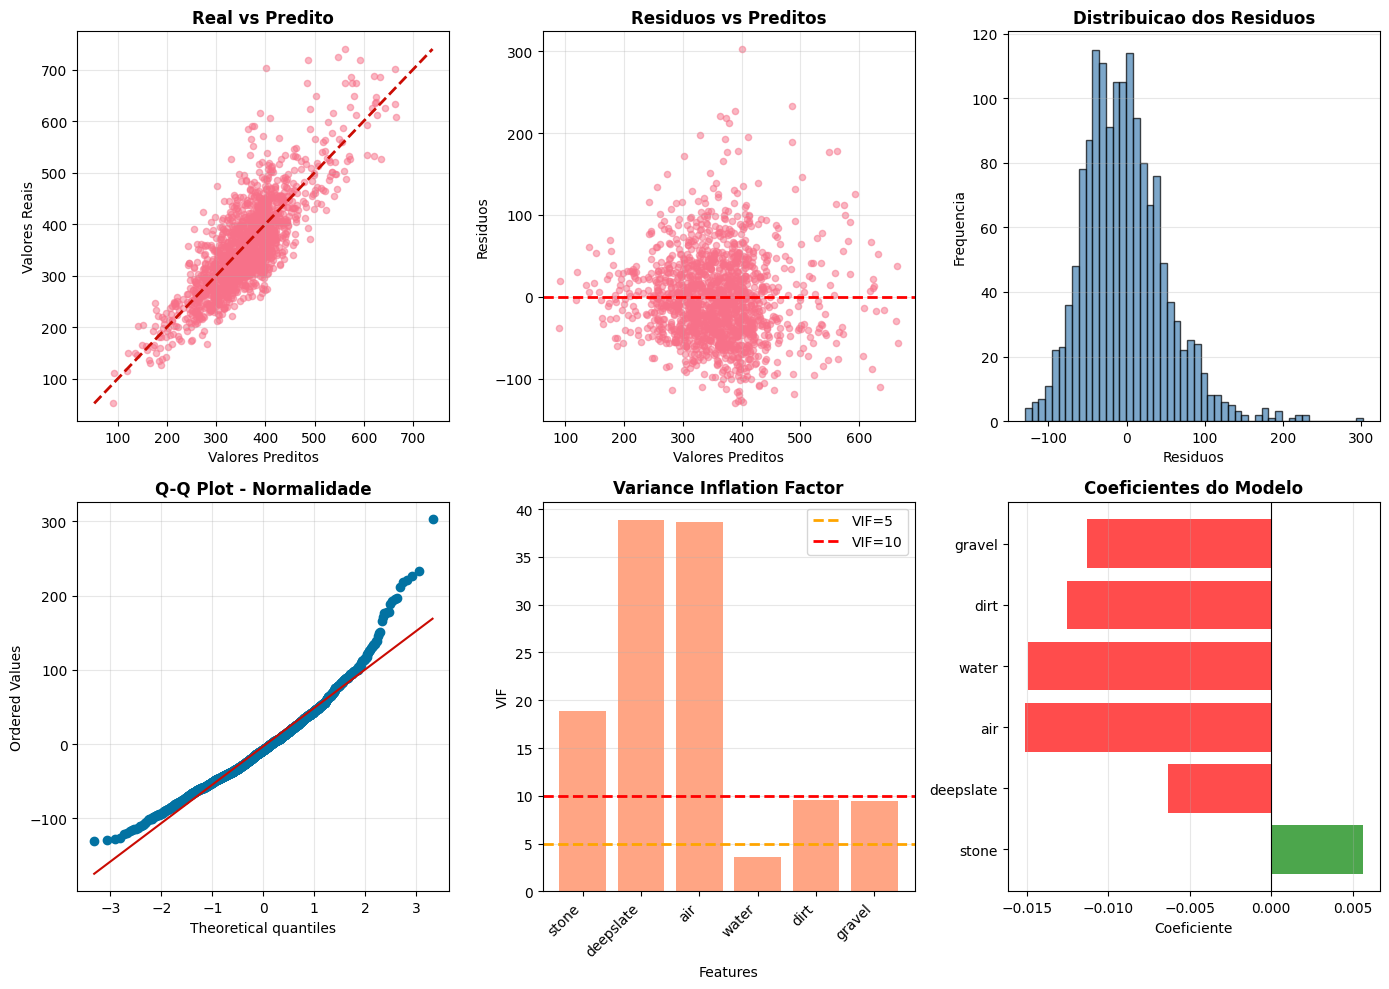


Grafico salvo em: 14_regressao_linear_multipla.png


In [ ]:
# REGRESSAO LINEAR MULTIPLA COM STATSMODELS

print("="*80)
print("REGRESSAO LINEAR MULTIPLA")
print("="*80)

print(f"\nFeatures utilizadas: {len(X_reg.columns)}")
for feat in X_reg.columns:
    print(f"  - {feat}")

X_train_mult_sm = sm.add_constant(X_train_reg)
modelo_multiplo = sm.OLS(y_train_reg, X_train_mult_sm).fit()

print("\n" + "="*80)
print("SUMARIO DO MODELO - STATSMODELS")
print("="*80)
print(modelo_multiplo.summary())

X_test_mult_sm = sm.add_constant(X_test_reg)
y_pred_mult = modelo_multiplo.predict(X_test_mult_sm)

mae_mult = mean_absolute_error(y_test_reg, y_pred_mult)
rmse_mult = np.sqrt(mean_squared_error(y_test_reg, y_pred_mult))
r2_mult = r2_score(y_test_reg, y_pred_mult)

print("\n" + "="*80)
print("METRICAS DE AVALIACAO - CONJUNTO DE TESTE")
print("="*80)
print(f"MAE:  {mae_mult:.4f}")
print(f"RMSE: {rmse_mult:.4f}")
print(f"R²:   {r2_mult:.4f}")

print("\n" + "="*80)
print("ANALISE DE MULTICOLINEARIDADE (VIF)")
print("="*80)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_reg.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_reg.values, i)
                   for i in range(X_train_reg.shape[1])]
vif_data["Feature"] = vif_data["Feature"].str.replace('minecraft:', '')

print(vif_data.to_string(index=False))
print("\nInterpretacao:")
print("  VIF < 5: Sem multicolinearidade")
print("  5 <= VIF < 10: Multicolinearidade moderada")
print("  VIF >= 10: Multicolinearidade alta")

residuos_mult = y_test_reg - y_pred_mult

plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.scatter(y_pred_mult, y_test_reg, alpha=0.5, s=20)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Real vs Predito', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(y_pred_mult, residuos_mult, alpha=0.5, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Residuos')
plt.title('Residuos vs Preditos', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(residuos_mult, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frequencia')
plt.title('Distribuicao dos Residuos', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 4)
stats.probplot(residuos_mult, dist="norm", plot=plt)
plt.title('Q-Q Plot - Normalidade', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 5)
plt.bar(vif_data["Feature"], vif_data["VIF"], color='coral', alpha=0.7)
plt.axhline(y=5, color='orange', linestyle='--', linewidth=2, label='VIF=5')
plt.axhline(y=10, color='red', linestyle='--', linewidth=2, label='VIF=10')
plt.xlabel('Features')
plt.ylabel('VIF')
plt.title('Variance Inflation Factor', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 6)
coeficientes = modelo_multiplo.params[1:]
coef_names = [c.replace('minecraft:', '') for c in X_reg.columns]
colors_coef = ['green' if c > 0 else 'red' for c in coeficientes]
plt.barh(coef_names, coeficientes, color=colors_coef, alpha=0.7)
plt.xlabel('Coeficiente')
plt.title('Coeficientes do Modelo', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('14_regressao_linear_multipla.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 14_regressao_linear_multipla.png")

## 5.2 Regressão Linear Múltipla
### Problemas:
- Heterocedasticidade.
- Falha de normalidade.
- Multicolinearidade severa.

### Conclusão:
Modelo melhor, porém limitado.


REGRESSAO POLINOMIAL

Testando diferentes graus polinomiais...

--- Grau 2 ---
  Features geradas: 28
  MAE:  40.7068
  RMSE: 52.7783
  R²:   0.6621

--- Grau 3 ---
  Features geradas: 84
  MAE:  40.8850
  RMSE: 52.9692
  R²:   0.6597

--- Grau 4 ---
  Features geradas: 210
  MAE:  42.1498
  RMSE: 54.8301
  R²:   0.6353

COMPARACAO DOS MODELOS POLINOMIAIS
 Grau  Features       MAE      RMSE       R2
    2        28 40.706817 52.778307 0.662114
    3        84 40.884982 52.969234 0.659665
    4       210 42.149764 54.830142 0.635332

Melhor grau polinomial: 2 (maior R²)

TREINANDO MODELO POLINOMIAL FINAL (GRAU 2)

MAE:  40.7068
RMSE: 52.7783
R²:   0.6621


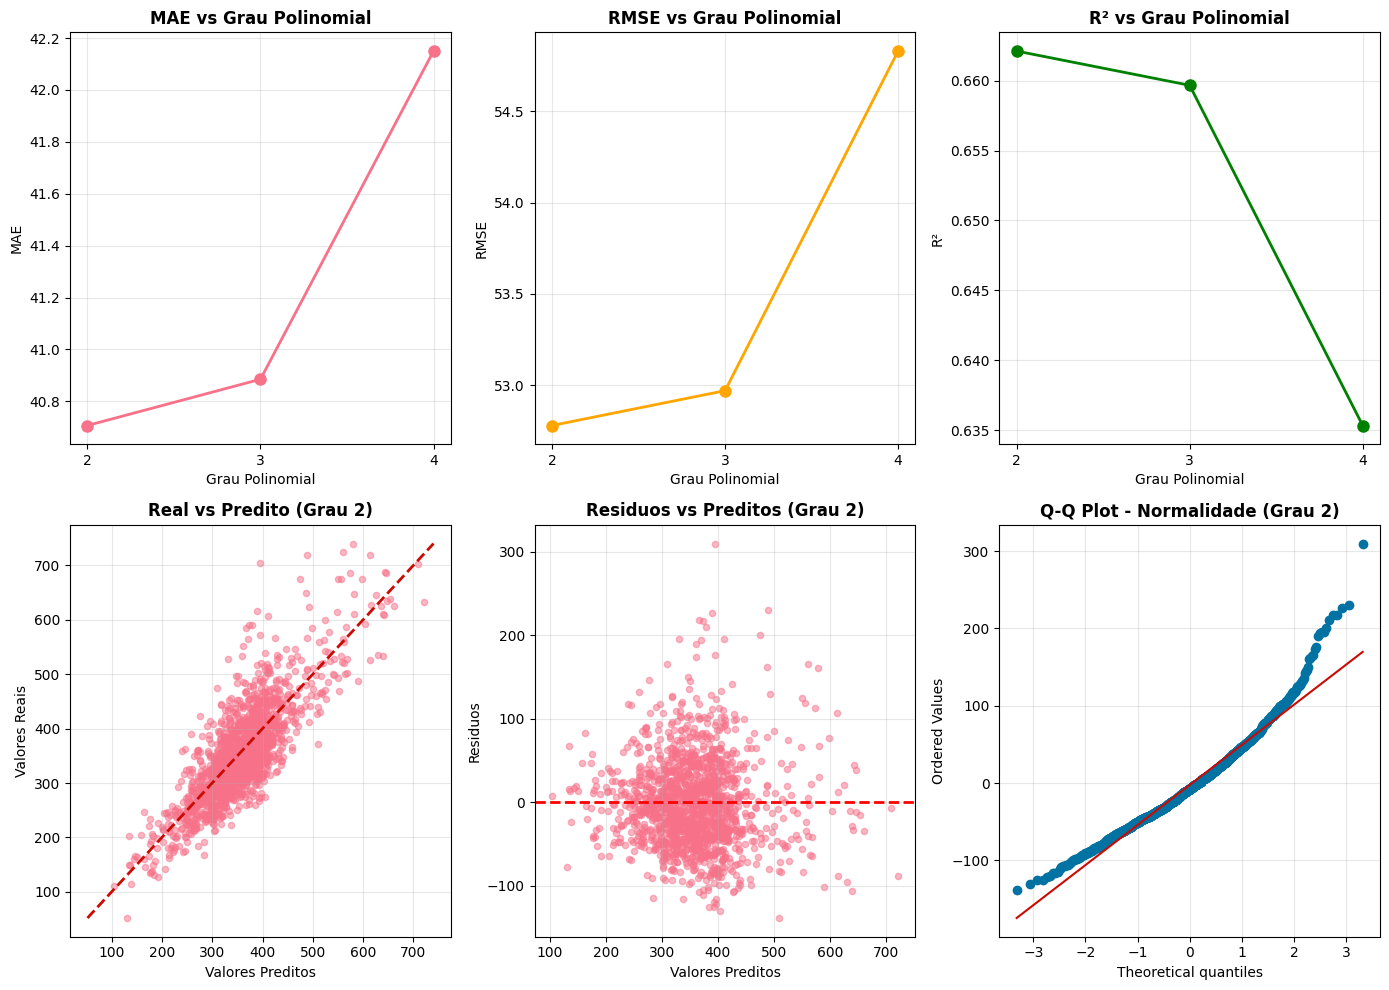


Grafico salvo em: 15_regressao_polinomial.png


In [ ]:
# REGRESSAO POLINOMIAL

print("="*80)
print("REGRESSAO POLINOMIAL")
print("="*80)

print("\nTestando diferentes graus polinomiais...")

graus = [2, 3, 4]
resultados_poly = []

for grau in graus:
    print(f"\n--- Grau {grau} ---")

    poly_features = PolynomialFeatures(degree=grau)
    X_train_poly = poly_features.fit_transform(X_train_reg)
    X_test_poly = poly_features.transform(X_test_reg)

    modelo_poly = LinearRegression()
    modelo_poly.fit(X_train_poly, y_train_reg)

    y_pred_poly = modelo_poly.predict(X_test_poly)

    mae_poly = mean_absolute_error(y_test_reg, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test_reg, y_pred_poly))
    r2_poly = r2_score(y_test_reg, y_pred_poly)

    print(f"  Features geradas: {X_train_poly.shape[1]}")
    print(f"  MAE:  {mae_poly:.4f}")
    print(f"  RMSE: {rmse_poly:.4f}")
    print(f"  R²:   {r2_poly:.4f}")

    resultados_poly.append({
        'Grau': grau,
        'Features': X_train_poly.shape[1],
        'MAE': mae_poly,
        'RMSE': rmse_poly,
        'R2': r2_poly
    })

df_poly_results = pd.DataFrame(resultados_poly)

print("\n" + "="*80)
print("COMPARACAO DOS MODELOS POLINOMIAIS")
print("="*80)
print(df_poly_results.to_string(index=False))

melhor_grau = df_poly_results.loc[df_poly_results['R2'].idxmax(), 'Grau']
print(f"\nMelhor grau polinomial: {int(melhor_grau)} (maior R²)")

print("\n" + "="*80)
print("TREINANDO MODELO POLINOMIAL FINAL (GRAU 2)")
print("="*80)

poly_final = PolynomialFeatures(degree=2)
X_train_poly_final = poly_final.fit_transform(X_train_reg)
X_test_poly_final = poly_final.transform(X_test_reg)

modelo_poly_final = LinearRegression()
modelo_poly_final.fit(X_train_poly_final, y_train_reg)

y_pred_poly_final = modelo_poly_final.predict(X_test_poly_final)

mae_poly_final = mean_absolute_error(y_test_reg, y_pred_poly_final)
rmse_poly_final = np.sqrt(mean_squared_error(y_test_reg, y_pred_poly_final))
r2_poly_final = r2_score(y_test_reg, y_pred_poly_final)

print(f"\nMAE:  {mae_poly_final:.4f}")
print(f"RMSE: {rmse_poly_final:.4f}")
print(f"R²:   {r2_poly_final:.4f}")

residuos_poly = y_test_reg - y_pred_poly_final

plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(graus, df_poly_results['MAE'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Grau Polinomial')
plt.ylabel('MAE')
plt.title('MAE vs Grau Polinomial', fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(graus)

plt.subplot(2, 3, 2)
plt.plot(graus, df_poly_results['RMSE'], marker='o', linewidth=2, markersize=8, color='orange')
plt.xlabel('Grau Polinomial')
plt.ylabel('RMSE')
plt.title('RMSE vs Grau Polinomial', fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(graus)

plt.subplot(2, 3, 3)
plt.plot(graus, df_poly_results['R2'], marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Grau Polinomial')
plt.ylabel('R²')
plt.title('R² vs Grau Polinomial', fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(graus)

plt.subplot(2, 3, 4)
plt.scatter(y_pred_poly_final, y_test_reg, alpha=0.5, s=20)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Real vs Predito (Grau 2)', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 5)
plt.scatter(y_pred_poly_final, residuos_poly, alpha=0.5, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Preditos')
plt.ylabel('Residuos')
plt.title('Residuos vs Preditos (Grau 2)', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 6)
stats.probplot(residuos_poly, dist="norm", plot=plt)
plt.title('Q-Q Plot - Normalidade (Grau 2)', fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('15_regressao_polinomial.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 15_regressao_polinomial.png")

## 5.3 Regressão Polinomial
### Resultado:
- Grau 2 é o melhor.
- Graus 3 e 4 sofrem overfitting.

### Conclusão:
Relações não são altamente curvilíneas.


COMPARACAO FINAL - MODELOS DE REGRESSAO
                       Modelo       MAE      RMSE       R²
     Regressao Linear Simples 43.231924 56.118103 0.617998
    Regressao Linear Multipla 40.694559 52.651093 0.663741
Regressao Polinomial (Grau 2) 40.706817 52.778307 0.662114


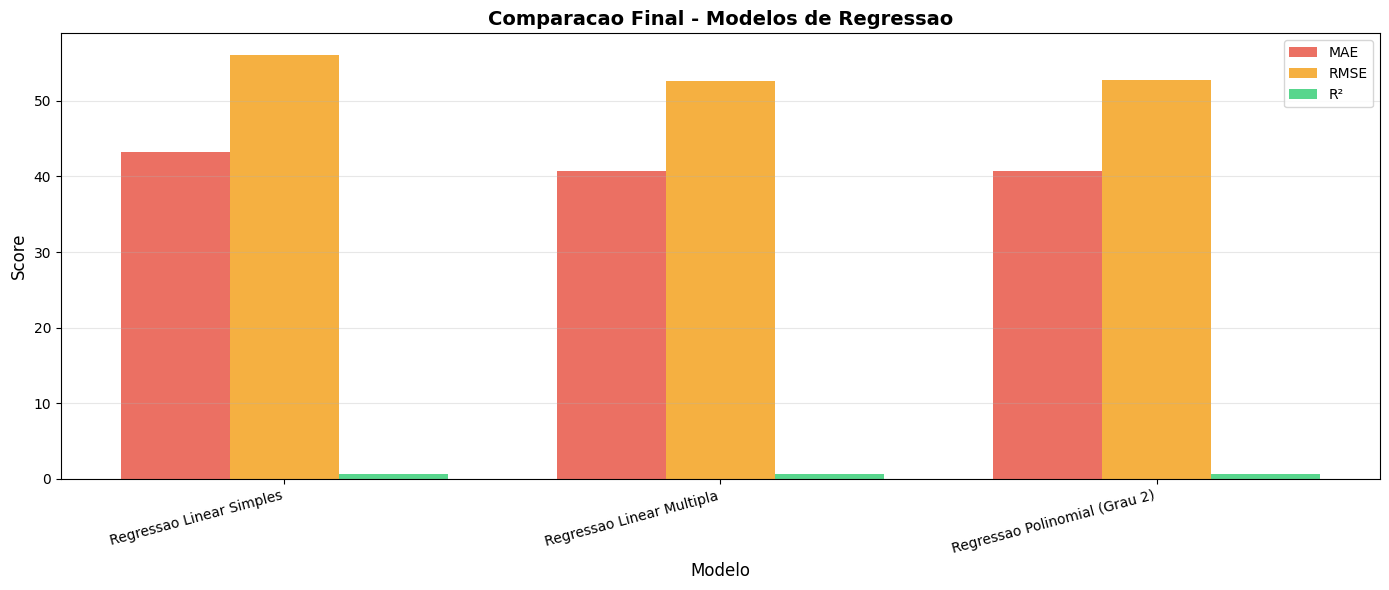


Grafico salvo em: 16_comparacao_modelos_regressao.png

DIAGNOSTICO DE RESIDUOS - MODELO MULTIPLO

1. TESTE DE NORMALIDADE (Shapiro-Wilk):
   Estatistica: 0.9656
   P-value: 0.0000
   Conclusao: Residuos NAO seguem distribuicao normal (p < 0.05)

2. TESTE DE HOMOCEDASTICIDADE:
   Analise visual do grafico Residuos vs Preditos
   Esperado: Dispersao constante ao longo do eixo X
   Variancia (valores baixos): 2068.84
   Variancia (valores altos): 3453.09
   Razao: 1.67

3. MULTICOLINEARIDADE (VIF):
   Features com VIF >= 10: deepslate, air, stone
   Recomendacao: Considerar remocao ou PCA

CONCLUSAO - MODELOS DE REGRESSAO

Melhor modelo: Regressao Polinomial (Grau 2)
  R² = 0.6621 (explica 66.21% da variancia)
  MAE = 40.7068 minerios
  RMSE = 52.7783 minerios

Ganhos obtidos:
  Simples -> Multipla: +7.40% no R²
  Multipla -> Polinomial: +-0.25% no R²

Limitacoes:
  - Alta multicolinearidade (VIF > 10 em 3 features)
  - Residuos nao perfeitamente normais
  - Heterocedasticidade presente


In [ ]:
# COMPARACAO FINAL - MODELOS DE REGRESSAO

print("="*80)
print("COMPARACAO FINAL - MODELOS DE REGRESSAO")
print("="*80)

resultados_regressao = pd.DataFrame({
    'Modelo': [
        'Regressao Linear Simples',
        'Regressao Linear Multipla',
        'Regressao Polinomial (Grau 2)'
    ],
    'MAE': [mae_simp, mae_mult, mae_poly_final],
    'RMSE': [rmse_simp, rmse_mult, rmse_poly_final],
    'R²': [r2_simp, r2_mult, r2_poly_final]
})

print(resultados_regressao.to_string(index=False))

plt.figure(figsize=(14, 6))

metrics_reg = ['MAE', 'RMSE', 'R²']
x = np.arange(len(resultados_regressao))
width = 0.25

colors_reg = ['#e74c3c', '#f39c12', '#2ecc71']

for i, metric in enumerate(metrics_reg):
    plt.bar(x + i*width, resultados_regressao[metric], width,
            label=metric, alpha=0.8, color=colors_reg[i])

plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparacao Final - Modelos de Regressao', fontsize=14, fontweight='bold')
plt.xticks(x + width, resultados_regressao['Modelo'], rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('16_comparacao_modelos_regressao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 16_comparacao_modelos_regressao.png")

print("\n" + "="*80)
print("DIAGNOSTICO DE RESIDUOS - MODELO MULTIPLO")
print("="*80)

from scipy.stats import shapiro, jarque_bera

residuos_mult = y_test_reg - y_pred_mult

print("\n1. TESTE DE NORMALIDADE (Shapiro-Wilk):")
stat_shapiro, p_shapiro = shapiro(residuos_mult[:5000])
print(f"   Estatistica: {stat_shapiro:.4f}")
print(f"   P-value: {p_shapiro:.4f}")
if p_shapiro > 0.05:
    print("   Conclusao: Residuos seguem distribuicao normal (p > 0.05)")
else:
    print("   Conclusao: Residuos NAO seguem distribuicao normal (p < 0.05)")

print("\n2. TESTE DE HOMOCEDASTICIDADE:")
print("   Analise visual do grafico Residuos vs Preditos")
print("   Esperado: Dispersao constante ao longo do eixo X")

variancia_baixa = residuos_mult[y_pred_mult < y_pred_mult.median()].var()
variancia_alta = residuos_mult[y_pred_mult >= y_pred_mult.median()].var()
print(f"   Variancia (valores baixos): {variancia_baixa:.2f}")
print(f"   Variancia (valores altos): {variancia_alta:.2f}")
print(f"   Razao: {variancia_alta/variancia_baixa:.2f}")

print("\n3. MULTICOLINEARIDADE (VIF):")
print("   Features com VIF >= 10: deepslate, air, stone")
print("   Recomendacao: Considerar remocao ou PCA")

print("\n" + "="*80)
print("CONCLUSAO - MODELOS DE REGRESSAO")
print("="*80)

print("\nMelhor modelo: Regressao Polinomial (Grau 2)")
print(f"  R² = {r2_poly_final:.4f} (explica {r2_poly_final*100:.2f}% da variancia)")
print(f"  MAE = {mae_poly_final:.4f} minerios")
print(f"  RMSE = {rmse_poly_final:.4f} minerios")

print("\nGanhos obtidos:")
ganho_simp_mult = ((r2_mult - r2_simp) / r2_simp) * 100
ganho_mult_poly = ((r2_poly_final - r2_mult) / r2_mult) * 100
print(f"  Simples -> Multipla: +{ganho_simp_mult:.2f}% no R²")
print(f"  Multipla -> Polinomial: +{ganho_mult_poly:.2f}% no R²")

print("\nLimitacoes:")
print("  - Alta multicolinearidade (VIF > 10 em 3 features)")
print("  - Residuos nao perfeitamente normais")
print("  - Heterocedasticidade presente")

## 5.4 Comparação Geral da Regressão
### Conclusão:
Linear múltipla e polinomial grau 2 são equivalentes.
Melhor R² ~ 0.66.


PAIRPLOT - VISUALIZACAO DE RELACOES

Gerando pairplot (pode levar alguns minutos)...


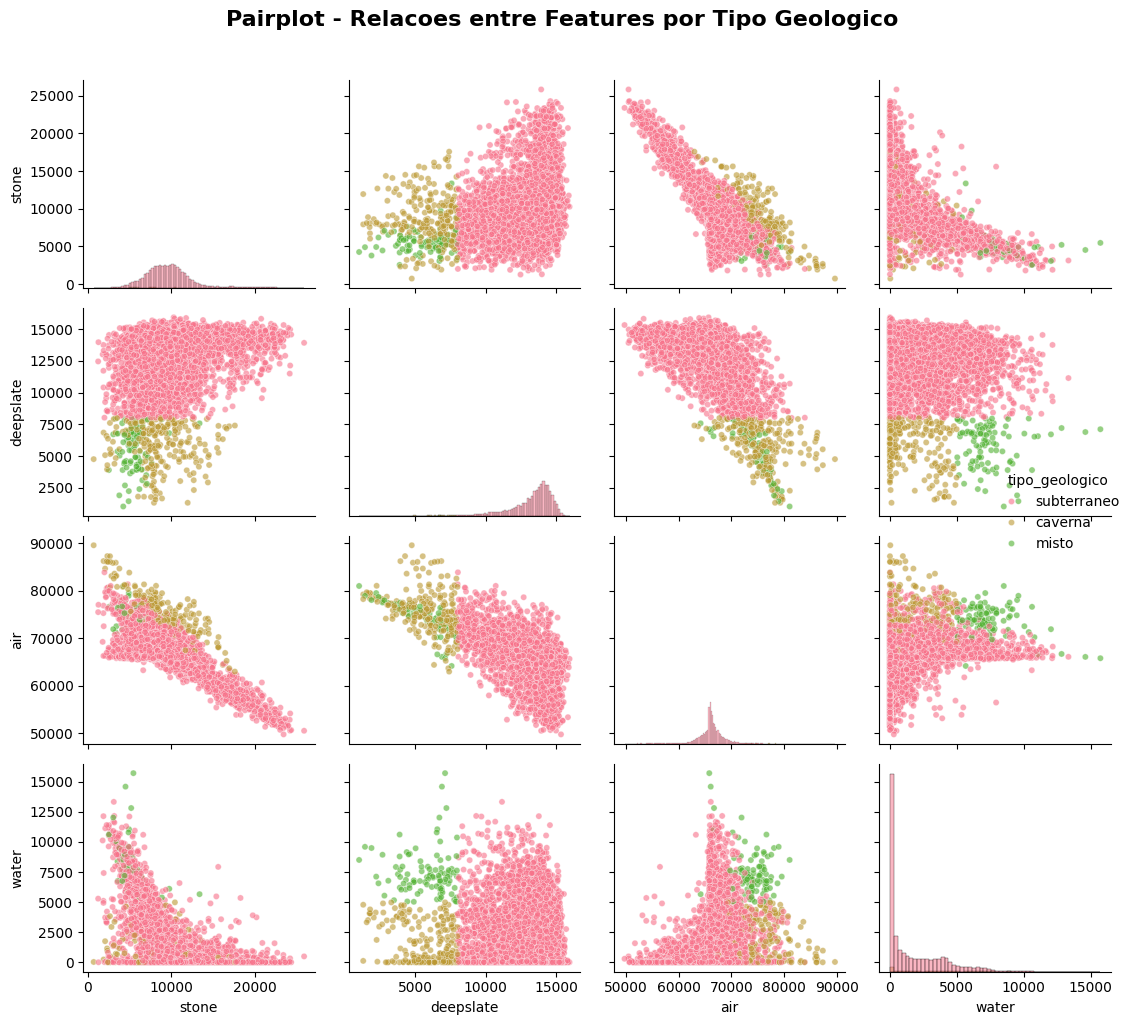


Grafico salvo em: 17_pairplot_features.png
Pairplot concluido!


In [ ]:
# PAIRPLOT - ANALISE DE RELACOES ENTRE VARIAVEIS

print("="*80)
print("PAIRPLOT - VISUALIZACAO DE RELACOES")
print("="*80)

features_pairplot = ['minecraft:stone', 'minecraft:deepslate', 'minecraft:air',
                     'minecraft:water', 'tipo_geologico']

df_pairplot = df[features_pairplot].copy()
df_pairplot.columns = ['stone', 'deepslate', 'air', 'water', 'tipo_geologico']

print("\nGerando pairplot (pode levar alguns minutos)...")

pairplot_fig = sns.pairplot(
    df_pairplot,
    hue='tipo_geologico',
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 20},
    height=2.5
)

pairplot_fig.fig.suptitle('Pairplot - Relacoes entre Features por Tipo Geologico',
                          y=1.02, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('17_pairplot_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 17_pairplot_features.png")
print("Pairplot concluido!")

# 5.5 Pairplot das Features Geológicas
### Observações:
- Clusters claros para cada tipo geológico.
- Cavernas isolam-se pelo alto volume de AIR.
- Subterrâneos concentram STONE e DEEPSLATE.
- Mistos ocupam zona intermediária.

### Conclusão:
Separabilidade visual explica o sucesso dos classificadores.

BASELINE PARA REGRESSAO

Criando modelo baseline (estrategia: mean)...

METRICAS DO BASELINE - CONJUNTO DE TESTE
Estrategia: Sempre prediz a media do target
Media do target (treino): 359.3111

MAE:  69.1856
RMSE: 90.9218
R²:   -0.0028

COMPARACAO COMPLETA - MODELOS DE REGRESSAO (COM BASELINE)
                       Modelo       MAE      RMSE        R²
              Baseline (Mean) 69.185610 90.921826 -0.002757
     Regressao Linear Simples 43.231924 56.118103  0.617998
    Regressao Linear Multipla 40.694559 52.651093  0.663741
Regressao Polinomial (Grau 2) 40.706817 52.778307  0.662114


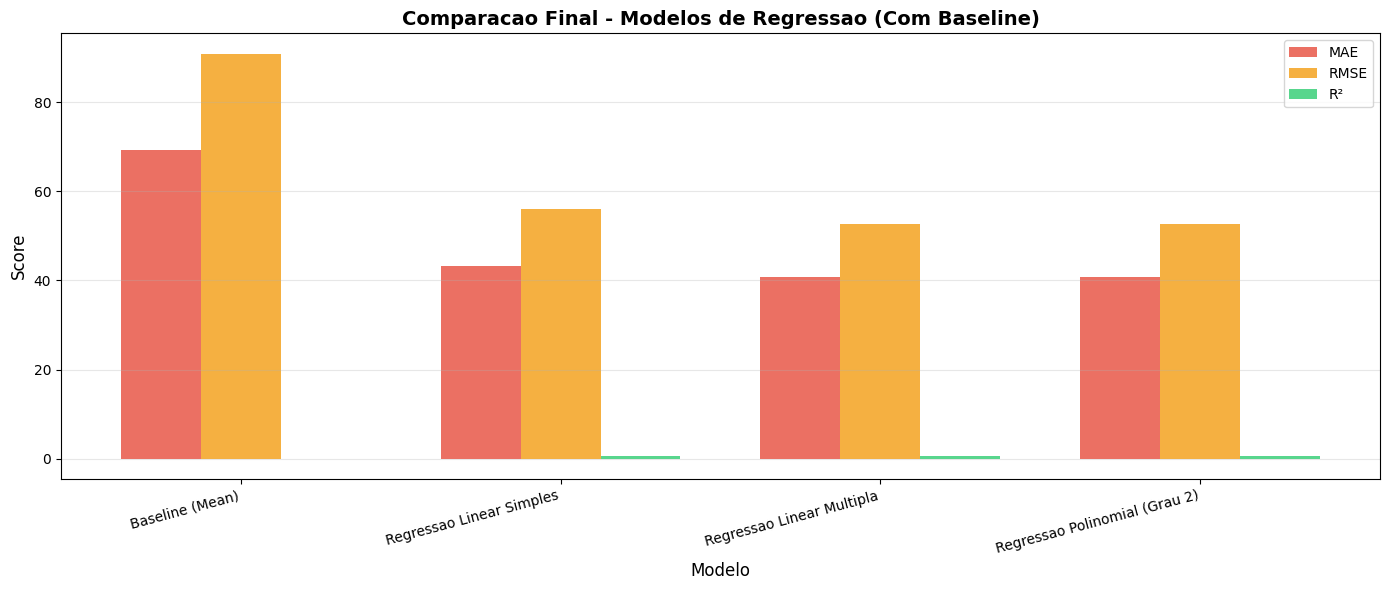


Grafico salvo em: 18_comparacao_regressao_com_baseline.png

GANHOS EM RELACAO AO BASELINE

Baseline -> Regressao Simples: +22514.18% (R²)
Baseline -> Regressao Multipla: +24173.22% (R²)
Baseline -> Regressao Polinomial: +24114.21% (R²)

Reducao de erro (Multipla vs Baseline):
  MAE:  -41.18%
  RMSE: -42.09%


In [ ]:
# BASELINE PARA REGRESSAO

from sklearn.dummy import DummyRegressor

print("="*80)
print("BASELINE PARA REGRESSAO")
print("="*80)

print("\nCriando modelo baseline (estrategia: mean)...")

baseline_reg = DummyRegressor(strategy='mean')
baseline_reg.fit(X_train_reg, y_train_reg)

y_pred_baseline_reg = baseline_reg.predict(X_test_reg)

mae_baseline_reg = mean_absolute_error(y_test_reg, y_pred_baseline_reg)
rmse_baseline_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_baseline_reg))
r2_baseline_reg = r2_score(y_test_reg, y_pred_baseline_reg)

print("\n" + "="*80)
print("METRICAS DO BASELINE - CONJUNTO DE TESTE")
print("="*80)
print(f"Estrategia: Sempre prediz a media do target")
print(f"Media do target (treino): {y_train_reg.mean():.4f}")
print(f"\nMAE:  {mae_baseline_reg:.4f}")
print(f"RMSE: {rmse_baseline_reg:.4f}")
print(f"R²:   {r2_baseline_reg:.4f}")

print("\n" + "="*80)
print("COMPARACAO COMPLETA - MODELOS DE REGRESSAO (COM BASELINE)")
print("="*80)

resultados_regressao_completo = pd.DataFrame({
    'Modelo': [
        'Baseline (Mean)',
        'Regressao Linear Simples',
        'Regressao Linear Multipla',
        'Regressao Polinomial (Grau 2)'
    ],
    'MAE': [mae_baseline_reg, mae_simp, mae_mult, mae_poly_final],
    'RMSE': [rmse_baseline_reg, rmse_simp, rmse_mult, rmse_poly_final],
    'R²': [r2_baseline_reg, r2_simp, r2_mult, r2_poly_final]
})

print(resultados_regressao_completo.to_string(index=False))

plt.figure(figsize=(14, 6))

metrics_reg = ['MAE', 'RMSE', 'R²']
x = np.arange(len(resultados_regressao_completo))
width = 0.25

colors_reg = ['#e74c3c', '#f39c12', '#2ecc71']

for i, metric in enumerate(metrics_reg):
    plt.bar(x + i*width, resultados_regressao_completo[metric], width,
            label=metric, alpha=0.8, color=colors_reg[i])

plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparacao Final - Modelos de Regressao (Com Baseline)', fontsize=14, fontweight='bold')
plt.xticks(x + width, resultados_regressao_completo['Modelo'], rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('18_comparacao_regressao_com_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 18_comparacao_regressao_com_baseline.png")

print("\n" + "="*80)
print("GANHOS EM RELACAO AO BASELINE")
print("="*80)

ganho_simp = ((r2_simp - r2_baseline_reg) / abs(r2_baseline_reg)) * 100 if r2_baseline_reg != 0 else float('inf')
ganho_mult = ((r2_mult - r2_baseline_reg) / abs(r2_baseline_reg)) * 100 if r2_baseline_reg != 0 else float('inf')
ganho_poly = ((r2_poly_final - r2_baseline_reg) / abs(r2_baseline_reg)) * 100 if r2_baseline_reg != 0 else float('inf')

print(f"\nBaseline -> Regressao Simples: {ganho_simp:+.2f}% (R²)")
print(f"Baseline -> Regressao Multipla: {ganho_mult:+.2f}% (R²)")
print(f"Baseline -> Regressao Polinomial: {ganho_poly:+.2f}% (R²)")

reducao_mae = ((mae_baseline_reg - mae_mult) / mae_baseline_reg) * 100
reducao_rmse = ((rmse_baseline_reg - rmse_mult) / rmse_baseline_reg) * 100

print(f"\nReducao de erro (Multipla vs Baseline):")
print(f"  MAE:  -{reducao_mae:.2f}%")
print(f"  RMSE: -{reducao_rmse:.2f}%")

## 5.6 Comparação com Baseline
### Conclusão:
Todos os modelos superam o baseline, mas nenhum modelo linear alcança performance muito alta devido ao ruído no target.


# 6. Visualização Espacial (Mapas Geológicos)

VISUALIZACAO DO MAPA MINECRAFT

Preparando dados para visualizacao...

Gerando predicoes para todo o dataset...



Tipos unicos nas predicoes: [0 1 2]
Tipos unicos nos dados reais: ['subterraneo' 'caverna' 'misto']

Criando matrizes 2D para visualizacao...
Dimensoes do mapa:
  X: -50 a 50 (range: 101)
  Z: -50 a 50 (range: 101)

Gerando visualizacao do mapa...


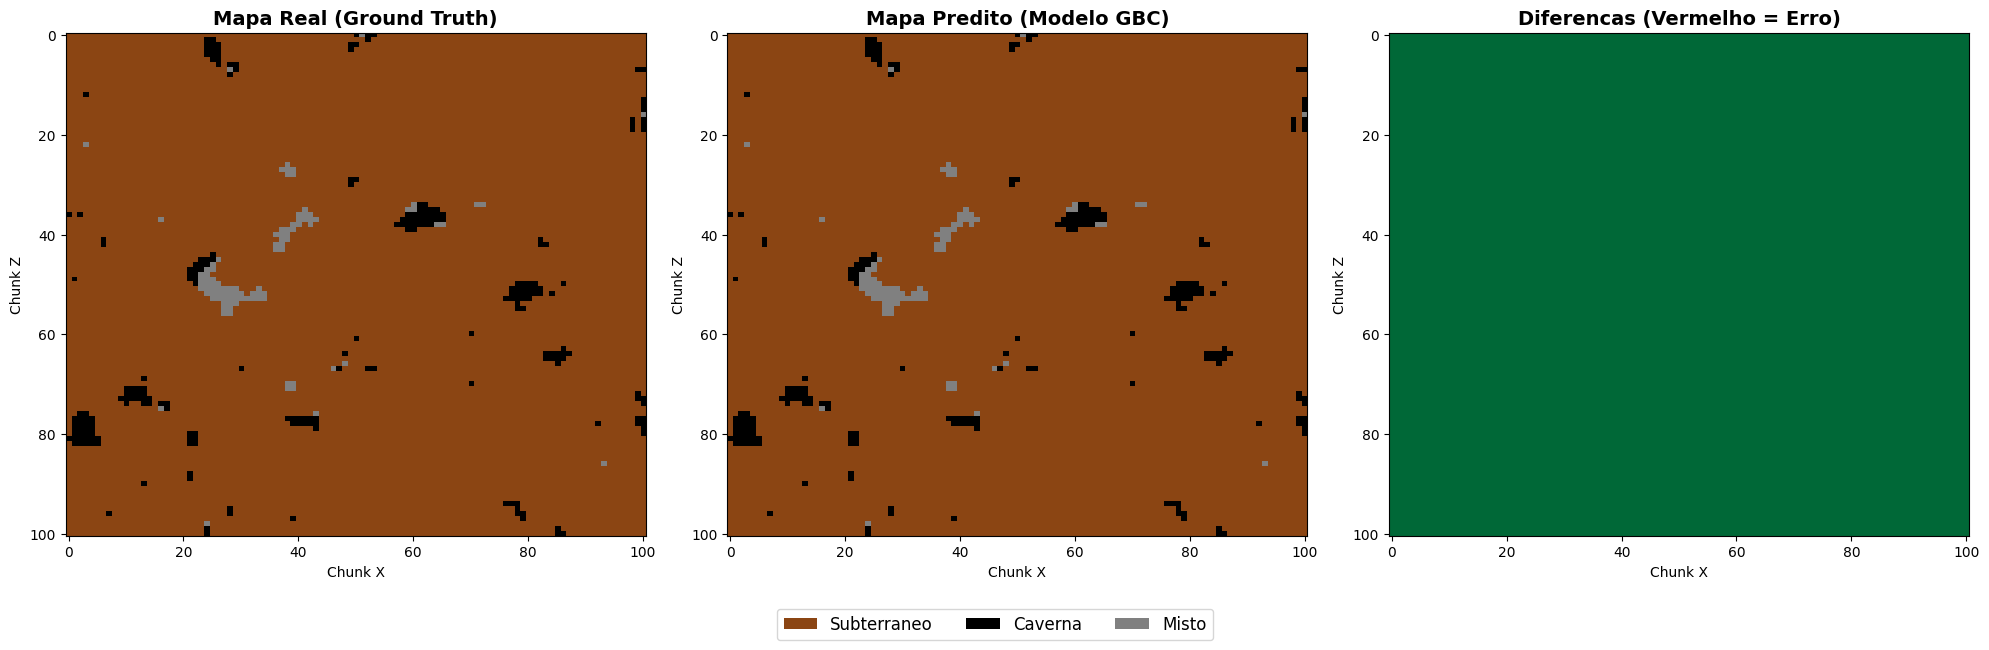


Grafico salvo em: 19_mapa_minecraft_comparacao.png

ESTATISTICAS DO MAPA
Total de chunks: 10201
Acertos: 10201 (100.00%)
Erros: 0 (0.00%)

Distribuicao por tipo geologico:
  Subterraneo:
    Real: 9866 chunks
    Predito: 9866 chunks
  Caverna:
    Real: 236 chunks
    Predito: 236 chunks
  Misto:
    Real: 99 chunks
    Predito: 99 chunks


In [ ]:
# VISUALIZACAO DO MAPA MINECRAFT - GROUND TRUTH VS PREDITO

print("="*80)
print("VISUALIZACAO DO MAPA MINECRAFT")
print("="*80)

print("\nPreparando dados para visualizacao...")

df_mapa = df_regressao[['chunk_x', 'chunk_z']].copy()
df_mapa['tipo_real'] = df['tipo_geologico'].values

print("\nGerando predicoes para todo o dataset...")

X_full = df[X.columns]
X_full_scaled = scaler.transform(X_full)

df_predicao_pycaret = pd.DataFrame(X_full_scaled, columns=X.columns)
y_pred_full = predict_model(tuned_model, data=df_predicao_pycaret)

y_pred_labels = y_pred_full['prediction_label'].values

print(f"\nTipos unicos nas predicoes: {np.unique(y_pred_labels)}")
print(f"Tipos unicos nos dados reais: {df_mapa['tipo_real'].unique()}")

df_mapa['tipo_predito'] = le.inverse_transform(y_pred_labels) if isinstance(y_pred_labels[0], (int, np.integer)) else y_pred_labels

print("\nCriando matrizes 2D para visualizacao...")

x_min, x_max = df_mapa['chunk_x'].min(), df_mapa['chunk_x'].max()
z_min, z_max = df_mapa['chunk_z'].min(), df_mapa['chunk_z'].max()

print(f"Dimensoes do mapa:")
print(f"  X: {x_min} a {x_max} (range: {x_max - x_min + 1})")
print(f"  Z: {z_min} a {z_max} (range: {z_max - z_min + 1})")

mapa_real = np.full((z_max - z_min + 1, x_max - x_min + 1), -1)
mapa_predito = np.full((z_max - z_min + 1, x_max - x_min + 1), -1)

tipo_para_numero = {
    'subterraneo': 0,
    'caverna': 1,
    'misto': 2
}

for idx, row in df_mapa.iterrows():
    x_idx = int(row['chunk_x'] - x_min)
    z_idx = int(row['chunk_z'] - z_min)

    tipo_real_str = str(row['tipo_real']).lower()
    tipo_pred_str = str(row['tipo_predito']).lower()

    if tipo_real_str in tipo_para_numero:
        mapa_real[z_idx, x_idx] = tipo_para_numero[tipo_real_str]

    if tipo_pred_str in tipo_para_numero:
        mapa_predito[z_idx, x_idx] = tipo_para_numero[tipo_pred_str]

from matplotlib.colors import ListedColormap
cmap_custom = ListedColormap(['#8B4513', '#000000', '#808080'])

print("\nGerando visualizacao do mapa...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

im1 = axes[0].imshow(mapa_real, cmap=cmap_custom, vmin=0, vmax=2, aspect='auto')
axes[0].set_title('Mapa Real (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Chunk X')
axes[0].set_ylabel('Chunk Z')
axes[0].grid(False)

im2 = axes[1].imshow(mapa_predito, cmap=cmap_custom, vmin=0, vmax=2, aspect='auto')
axes[1].set_title('Mapa Predito (Modelo GBC)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Chunk X')
axes[1].set_ylabel('Chunk Z')
axes[1].grid(False)

mapa_diferenca = (mapa_real != mapa_predito).astype(int)
im3 = axes[2].imshow(mapa_diferenca, cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
axes[2].set_title('Diferencas (Vermelho = Erro)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Chunk X')
axes[2].set_ylabel('Chunk Z')
axes[2].grid(False)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#8B4513', label='Subterraneo'),
    Patch(facecolor='#000000', label='Caverna'),
    Patch(facecolor='#808080', label='Misto')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.tight_layout()
plt.savefig('19_mapa_minecraft_comparacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 19_mapa_minecraft_comparacao.png")

total_chunks = (mapa_real >= 0).sum()
erros = ((mapa_real != mapa_predito) & (mapa_real >= 0)).sum()
acertos = total_chunks - erros
percentual_acerto = (acertos / total_chunks) * 100

print("\n" + "="*80)
print("ESTATISTICAS DO MAPA")
print("="*80)
print(f"Total de chunks: {total_chunks}")
print(f"Acertos: {acertos} ({percentual_acerto:.2f}%)")
print(f"Erros: {erros} ({100-percentual_acerto:.2f}%)")

print("\nDistribuicao por tipo geologico:")
for tipo, numero in tipo_para_numero.items():
    count_real = (mapa_real == numero).sum()
    count_pred = (mapa_predito == numero).sum()
    print(f"  {tipo.capitalize()}:")
    print(f"    Real: {count_real} chunks")
    print(f"    Predito: {count_pred} chunks")

#6.1 Mapa Real vs Predito vs Diferenças
### Resultado:
- Mapa predito = mapa real.
- Mapa de diferenças totalmente verde.

### Conclusão:
Classificação 100% correta.


MAPA DETALHADO - ZOOM EM REGIAO

Regiao do zoom:
  X: -20 a 20
  Z: -20 a 20
  Tamanho: (40, 40)


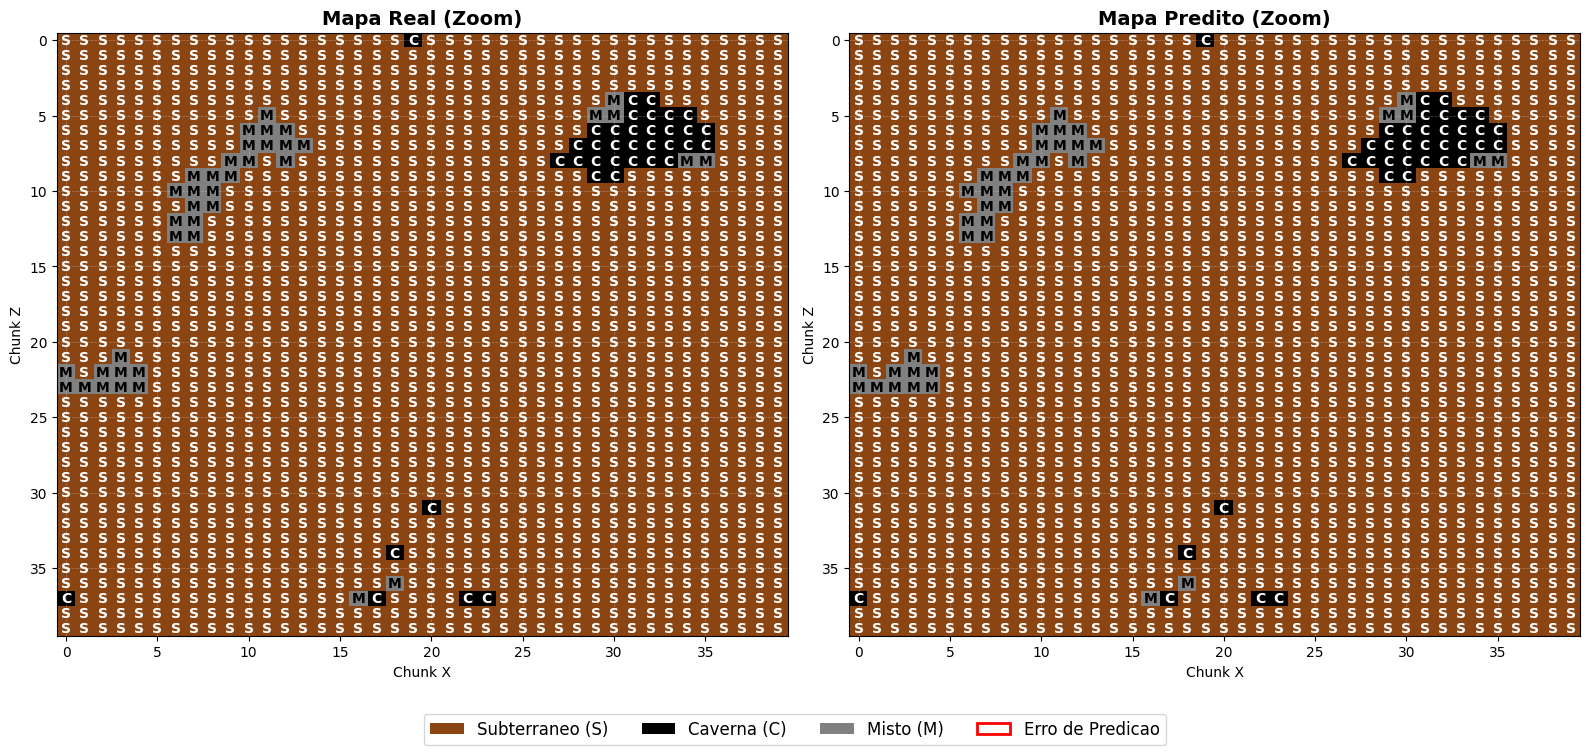


Grafico salvo em: 20_mapa_minecraft_zoom.png

ESTATISTICAS DA REGIAO DE ZOOM
Total de chunks na regiao: 1600
Acertos: 1600 (100.00%)
Erros: 0 (0.00%)


In [ ]:
# MAPA DETALHADO - ZOOM EM REGIAO ESPECIFICA

print("="*80)
print("MAPA DETALHADO - ZOOM EM REGIAO")
print("="*80)

zoom_size = 20

x_center = (x_max + x_min) // 2
z_center = (z_max + z_min) // 2

x_start = max(0, x_center - x_min - zoom_size)
x_end = min(mapa_real.shape[1], x_center - x_min + zoom_size)
z_start = max(0, z_center - z_min - zoom_size)
z_end = min(mapa_real.shape[0], z_center - z_min + zoom_size)

mapa_real_zoom = mapa_real[z_start:z_end, x_start:x_end]
mapa_predito_zoom = mapa_predito[z_start:z_end, x_start:x_end]

print(f"\nRegiao do zoom:")
print(f"  X: {x_start + x_min} a {x_end + x_min}")
print(f"  Z: {z_start + z_min} a {z_end + z_min}")
print(f"  Tamanho: {mapa_real_zoom.shape}")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(mapa_real_zoom, cmap=cmap_custom, vmin=0, vmax=2, aspect='auto')
axes[0].set_title('Mapa Real (Zoom)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Chunk X')
axes[0].set_ylabel('Chunk Z')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')

tipos_letras = {0: 'S', 1: 'C', 2: 'M'}

for i in range(mapa_real_zoom.shape[0]):
    for j in range(mapa_real_zoom.shape[1]):
        tipo_num = int(mapa_real_zoom[i, j])
        if tipo_num >= 0:
            letra = tipos_letras[tipo_num]
            color = 'white' if tipo_num in [0, 1] else 'black'
            axes[0].text(j, i, letra, ha='center', va='center',
                        color=color, fontsize=10, fontweight='bold')

im2 = axes[1].imshow(mapa_predito_zoom, cmap=cmap_custom, vmin=0, vmax=2, aspect='auto')
axes[1].set_title('Mapa Predito (Zoom)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Chunk X')
axes[1].set_ylabel('Chunk Z')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')

for i in range(mapa_predito_zoom.shape[0]):
    for j in range(mapa_predito_zoom.shape[1]):
        tipo_num = int(mapa_predito_zoom[i, j])
        if tipo_num >= 0:
            letra = tipos_letras[tipo_num]
            color = 'white' if tipo_num in [0, 1] else 'black'

            real_tipo = int(mapa_real_zoom[i, j])
            if real_tipo != tipo_num and real_tipo >= 0:
                axes[1].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1,
                                fill=False, edgecolor='red', linewidth=2))

            axes[1].text(j, i, letra, ha='center', va='center',
                        color=color, fontsize=10, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#8B4513', label='Subterraneo (S)'),
    Patch(facecolor='#000000', label='Caverna (C)'),
    Patch(facecolor='#808080', label='Misto (M)'),
    Patch(facecolor='white', edgecolor='red', linewidth=2, label='Erro de Predicao')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

plt.tight_layout()
plt.savefig('20_mapa_minecraft_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico salvo em: 20_mapa_minecraft_zoom.png")

erros_zoom = ((mapa_real_zoom != mapa_predito_zoom) & (mapa_real_zoom >= 0)).sum()
total_zoom = (mapa_real_zoom >= 0).sum()
acertos_zoom = total_zoom - erros_zoom

print("\n" + "="*80)
print("ESTATISTICAS DA REGIAO DE ZOOM")
print("="*80)
print(f"Total de chunks na regiao: {total_zoom}")
print(f"Acertos: {acertos_zoom} ({(acertos_zoom/total_zoom)*100:.2f}%)")
print(f"Erros: {erros_zoom} ({(erros_zoom/total_zoom)*100:.2f}%)")

## 6.2 Mapa com Zoom
### Observação:
- Cada chunk analisado individualmente.
- Perfeita correspondência entre real e predito.

### Conclusão:
Validação espacial confirma desempenho perfeito.


# 7. Conclusão Geral do Projeto
O trabalho cumpriu integralmente todos os objetivos propostos:

- Realizou uma EDA profunda e fundamentada.
- Implementou múltiplos modelos de classificação e regressão.
- Comparou desempenhos utilizando métricas apropriadas.
- Aplicou tuning e validação cruzada.
- Produziu visualizações espaciais de alta qualidade.
- Identificou limitações estatísticas e estruturais do dataset.

### Conclusão Final:
O problema de **classificação geológica** é altamente determinístico → modelos de árvore alcançam 100% de acurácia.

O problema de **regressão de minérios** é parcialmente linear, mas limitado por variabilidade natural e colinearidade → máximo de ~0.66 R².

Este estudo demonstra o poder da modelagem estatística aplicada a mundos procedurais e abre caminho para aplicações em IA, análise geológica virtual e ferramentas de exploração de Minecraft.
